# Binary Classification of Insurance Cross Selling (Draft!)
***Hi folks! This notebook is still in draft status, but I thought I'd share my progress along the way.***

*Note: This notebook is part of the Kaggle Playground series (season 4, episode 7). You can find more details about the competition [at this link.](https://www.kaggle.com/competitions/playground-series-s4e7/data)*

This notebook represents an end-to-end analysis and model creation for cross selling of insurance products. This notebook is broken down into the following sections.

- **About the Competition**: This section will provide an intuitive overview of what this competition is seeking to accomplish.
- **Personal Motivations**: This section covers a few of my personal motivations for this particular competition and explains why I've made some of the choices that I have.
- **Notebook Setup**: We'll set ourselves up for success by doing things like importing the necessary Python libraries and also loading our data. This notebook will also be set up to work either directly in a Kaggle notebook or in a local environment.
- **Exploratory Data Analysis (EDA)**: As with any data science effort, this section will look to gain an understanding of the data we're working with by producing things like visualizations around each feature.
- **Feature Engineering**: Following our EDA results, we will use this section to build the code we need to generate the appropriate features for the training the predictive model.
- **Predictive Modeling / Validation**
- **Final Pipeline Hardening / Submission Generation**
- **Closing Thoughts / Retrospective**

# About the Competition
In this Kaggle Playground competition, we are going to analyzing a synthesized version of another dataset around **Health Insurance Cross Sell Prediction**. As you can imagine, most insurers like to extend their business by offering different forms of insurance that can be bundled together. These offerings can range across auto, fire (aka home), life, health, and more.

Within this specific dataset, **a fictitious insurance company wants us to use their historical data to see if we can build a binary classifier on which of their existing health insurance customers might also be interested in purchasing an auto insurance policy.** Having this information is valuable for the company as it can help them to determine the best path forward in terms of things like marketing.

On submission for the competition, the leaderboard will be determined by the **ROC AUC Score (Receiver Operating Characteristic - Area Under the Curve)**. As such, we will use that as our ultimate evaluation metric on building candidate models.

# Personal Motivations
This is the very first Kaggle competition I've ever participated in in earnest! I know, I know, it's not a true competition, but it seems like a good way to get my feet wet. I am a principal machine learning engineer at a Fortune 50 company, and at my company, it's more so the focus of the data scientist role to build the predictive model. My role as a machine learning engineer is more around successful deployment of these models, so while my role does require general data science knowledge, I am not particularly an expert modeler.

That said, my general motivation for participating in this competition is to grow in my predictive modeling skills. Specifically, you will note that I rely on **Polars** throughout this notebook. I have extensive knowledge with Pandas but am more of a novice when it comes to Polars. As such, I thought this would be a good opportunity to leverage Polars throughout this competition.

One final note: I relied pretty heavily on Generative AI to work through this project. (Specifically, I used a Perplexity Pro subscription with Claude 3.5 Sonnet as the backend model.) To be clear, however, I didn't use it in a way that felt like "cheating", like asking the model to just flat out give me an answer. I used it more as a thought partner and learning companion. For example, I came up with some of the ideas to combine features together on my own, but I used the GenAI as a thought partner on other ways I could think about feature engineering.

# Notebook Setup
This section will set up everything that we will use in the remainder of the notebook. One thing to specifically note: I have imported my custom visualization functions from outside this notebook. If you would like to see the code behind these visualization tools, check out this link: [Visualization Tools](https://www.kaggle.com/code/dkhundley/visualization-tools). (Note: These visualization functions have been exclusively designed to work with Polars.)

In [1]:
# Importing the necessary Python libraries
import os
import sys

import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import chi2_contingency, pointbiserialr
from sklearn.metrics import roc_auc_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb

# Importing our custom utilities
if 'KAGGLE_URL_BASE' in os.environ:
    from visualization_tools import *
else:
    import kaggle
    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'utilities')))
    from visualization_tools import *
    from data_utilities import download_and_extract_kaggle_data

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Downloading the Kaggle data to a local environment
if 'KAGGLE_URL_BASE' not in os.environ:
    competition_name = 'playground-series-s4e7'
    download_and_extract_kaggle_data(competition_name)

Data for playground-series-s4e7 already exists in 'data/' directory.


In [3]:
# Loading the datasets as Polars DataFrames
if 'KAGGLE_URL_BASE' in os.environ:
    df = pl.read_csv('/kaggle/input/playground-series-s4e7/train.csv')
    df_test = pl.read_csv('/kaggle/input/playground-series-s4e7/test.csv')
    df_sample_submission = pl.read_csv('/kaggle/input/playground-series-s4e7/sample_submission.csv')
else:
    df = pl.read_csv('data/train.csv')
    df_test = pl.read_csv('data/test.csv')
    df_sample_submission = pl.read_csv('data/sample_submission.csv')

In [4]:
# Setting the visualization color theme
set_color_theme()

# Setting Boolean toggles to run certain bits of code
run_visualizations = True
run_hyperparameter_optimization = True

In [5]:
# Checking to see if the GPU is enabled
if 'KAGGLE_URL_BASE' in os.environ:
    
    import torch
    
    gpu_enabled = True if torch.cuda.is_available() else False
    
    if gpu_enabled:
        print('Kaggle GPU is enabled.')
    else:
        print('Kaggle GPU is not enabled.')

# Exploratory Data Analysis (EDA)
Now that we've loaded up our data, let's move into exploratory data analysis (EDA). The competition itself doesn't give us a whole lot of information about each data feature, so here is what my approach is going to be:

1. Since there are only 12 features, I don't think it's unfeasible to look at all of them at an individual level. This will include visualizations.
2. If I am still a bit hazy on what the feature represents, I'll check out the Kaggle discussion board to see if anybody has any particular insight.
3. After completing the univariate analysis as part of step 1, we will see opportunities for multivariate analysis for potential multivariate feature engineering.

On completing step 1 above, I found trying to understand what several of these features to mean to be lacking. Combing the Kaggle discussion board, I found one user reference [this other Kaggle dataset](https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction) that provides a more thorough description of each feature.

## Holistic EDA
Before we do a deep dive on each individual feature, let's do a holistic EDA on the dataset at a high level.

In [6]:
# Displaying the column names of the Polars DataFrame
df.columns

['id',
 'Gender',
 'Age',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage',
 'Response']

In [7]:
# Viewing the holistic statistics of the Polars DataFrame
df.describe()

statistic,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
str,f64,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64
"""count""",1.1504798e7,"""11504798""",1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7,"""11504798""","""11504798""",1.1504798e7,1.1504798e7,1.1504798e7,1.1504798e7
"""null_count""",0.0,"""0""",0.0,0.0,0.0,0.0,"""0""","""0""",0.0,0.0,0.0,0.0
"""mean""",5752398.5,null,38.383563,0.998022,26.41869,0.462997,null,null,30461.370411,112.425442,163.897744,0.122997
"""std""",3.3211e6,null,14.993459,0.044431,12.99159,0.498629,null,null,16454.745205,54.035708,79.979531,0.328434
"""min""",0.0,"""Female""",20.0,0.0,0.0,0.0,"""1-2 Year""","""No""",2630.0,1.0,10.0,0.0
"""25%""",2.876199e6,null,24.0,1.0,15.0,0.0,null,null,25277.0,29.0,99.0,0.0
"""50%""",5.752399e6,null,36.0,1.0,28.0,0.0,null,null,31824.0,151.0,166.0,0.0
"""75%""",8.628598e6,null,49.0,1.0,35.0,1.0,null,null,39451.0,152.0,232.0,0.0
"""max""",1.1504797e7,"""Male""",85.0,1.0,52.0,1.0,"""> 2 Years""","""Yes""",540165.0,163.0,299.0,1.0


## Univariate Analysis
Since there are relatively few features provided in this dataset, we're going to use this subsection to take a deeper look into each individual feature on its own.

### Feature 1: `id`
This one is pretty easy to deal with. It's simply a unique identifier for each row, so it does not offer any semantic value in trying to derive an inference. In simpler words, we can't do anything with it, so we'll end up getting rid of this feature before training the model.

**Feature Engineering Plans**:
- Drop the `id` feature entirely

### Feature 2: `Gender`
As the name implies, this feature represents a person's gender. The feature manifests in a binary state, meaning that the only values found in this feature include `Male` and `Female`.

**Feature Engineering Plans**:
- Encode the `Gender` feature into numerical form.

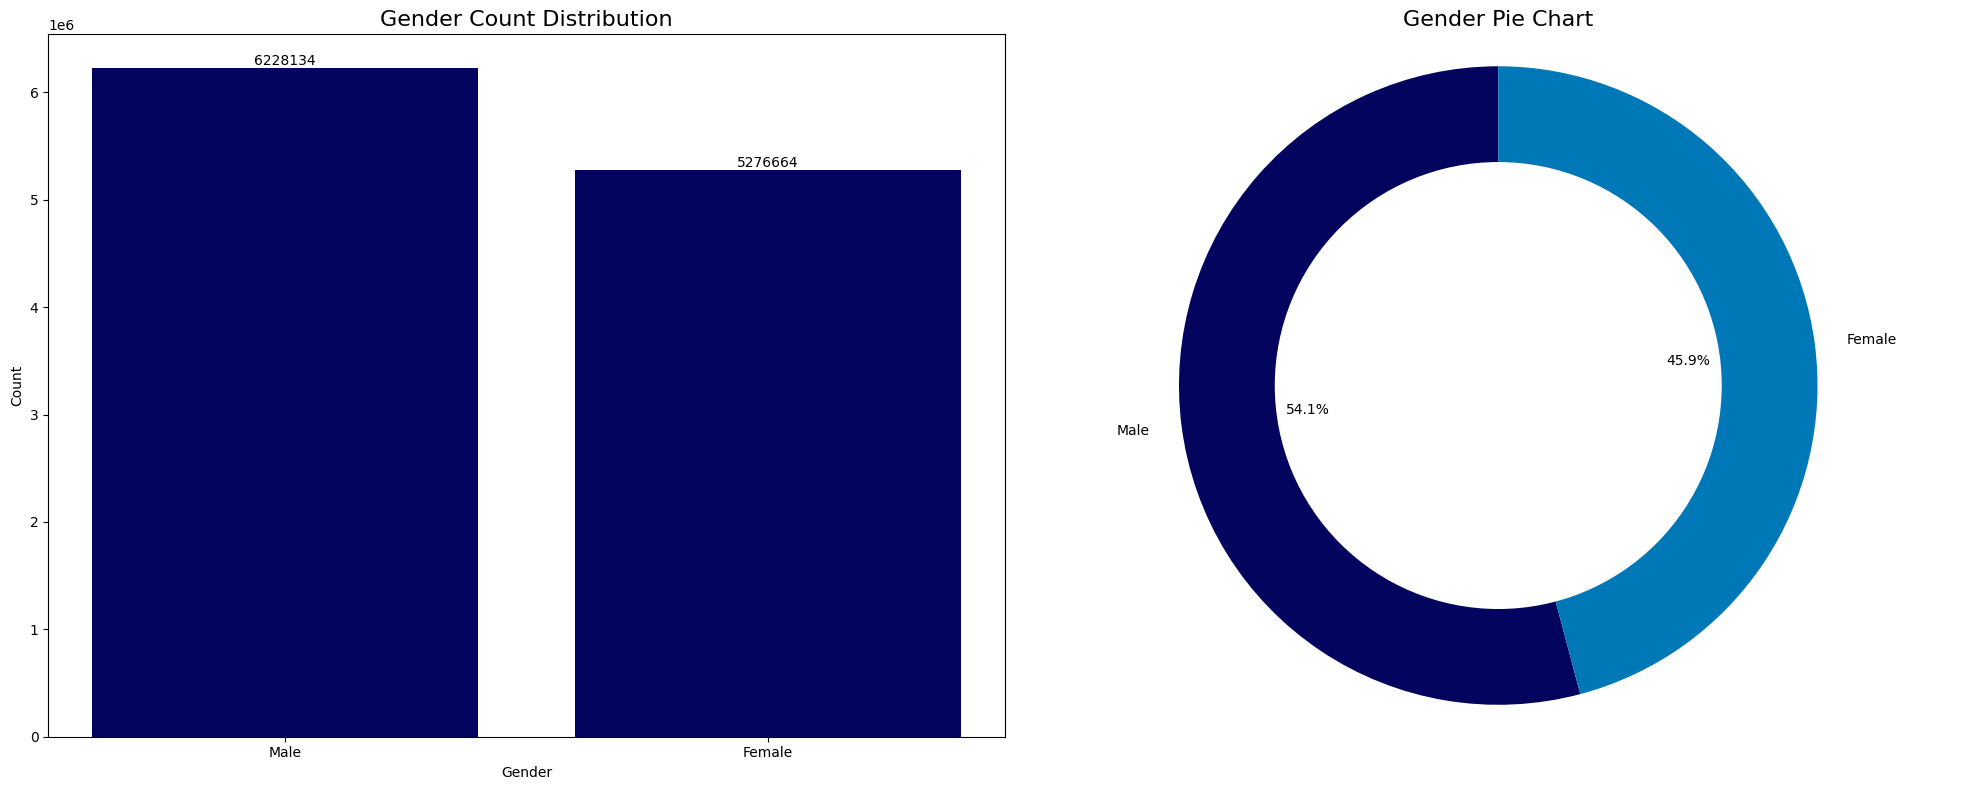

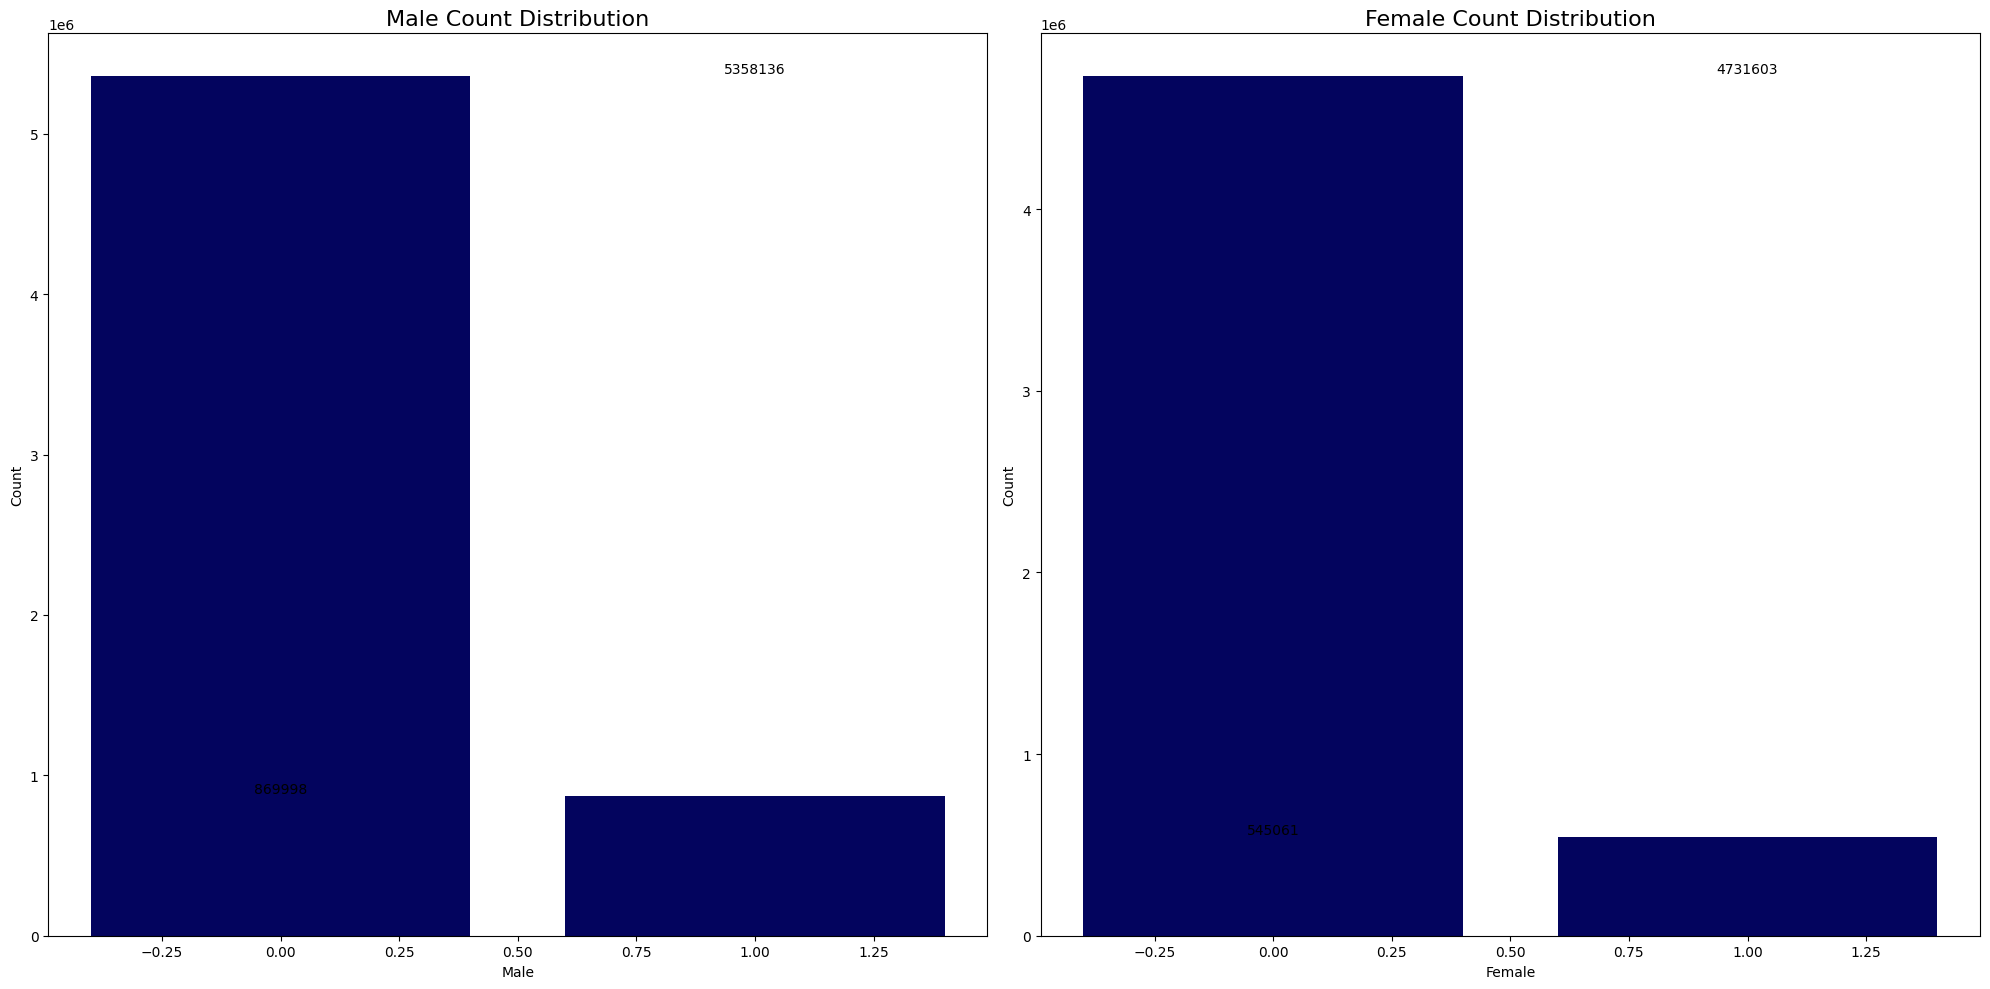

In [8]:
# Displaying general visualizations around the Gender feature
if run_visualizations:
    display_binary_counts(binary_feat = df['Gender'])
    display_binary_class_to_target_class(
        df = df,
        feat_name = 'Gender',
        binary_classes = ['Male', 'Female'],
        target_class = 'Response'
    )

### Feature 3: `Age`
Visualizing the data below, we can determine that there is a bit of a bimodality thing going on. Specifically, we see spikes at the youngest age and then once again at around middle age.

**Feature Engineering Plans**:
- Use a Gaussian Mixture Model (GMM) to build a new feature around `Age` given the bimodal spikes in the data.

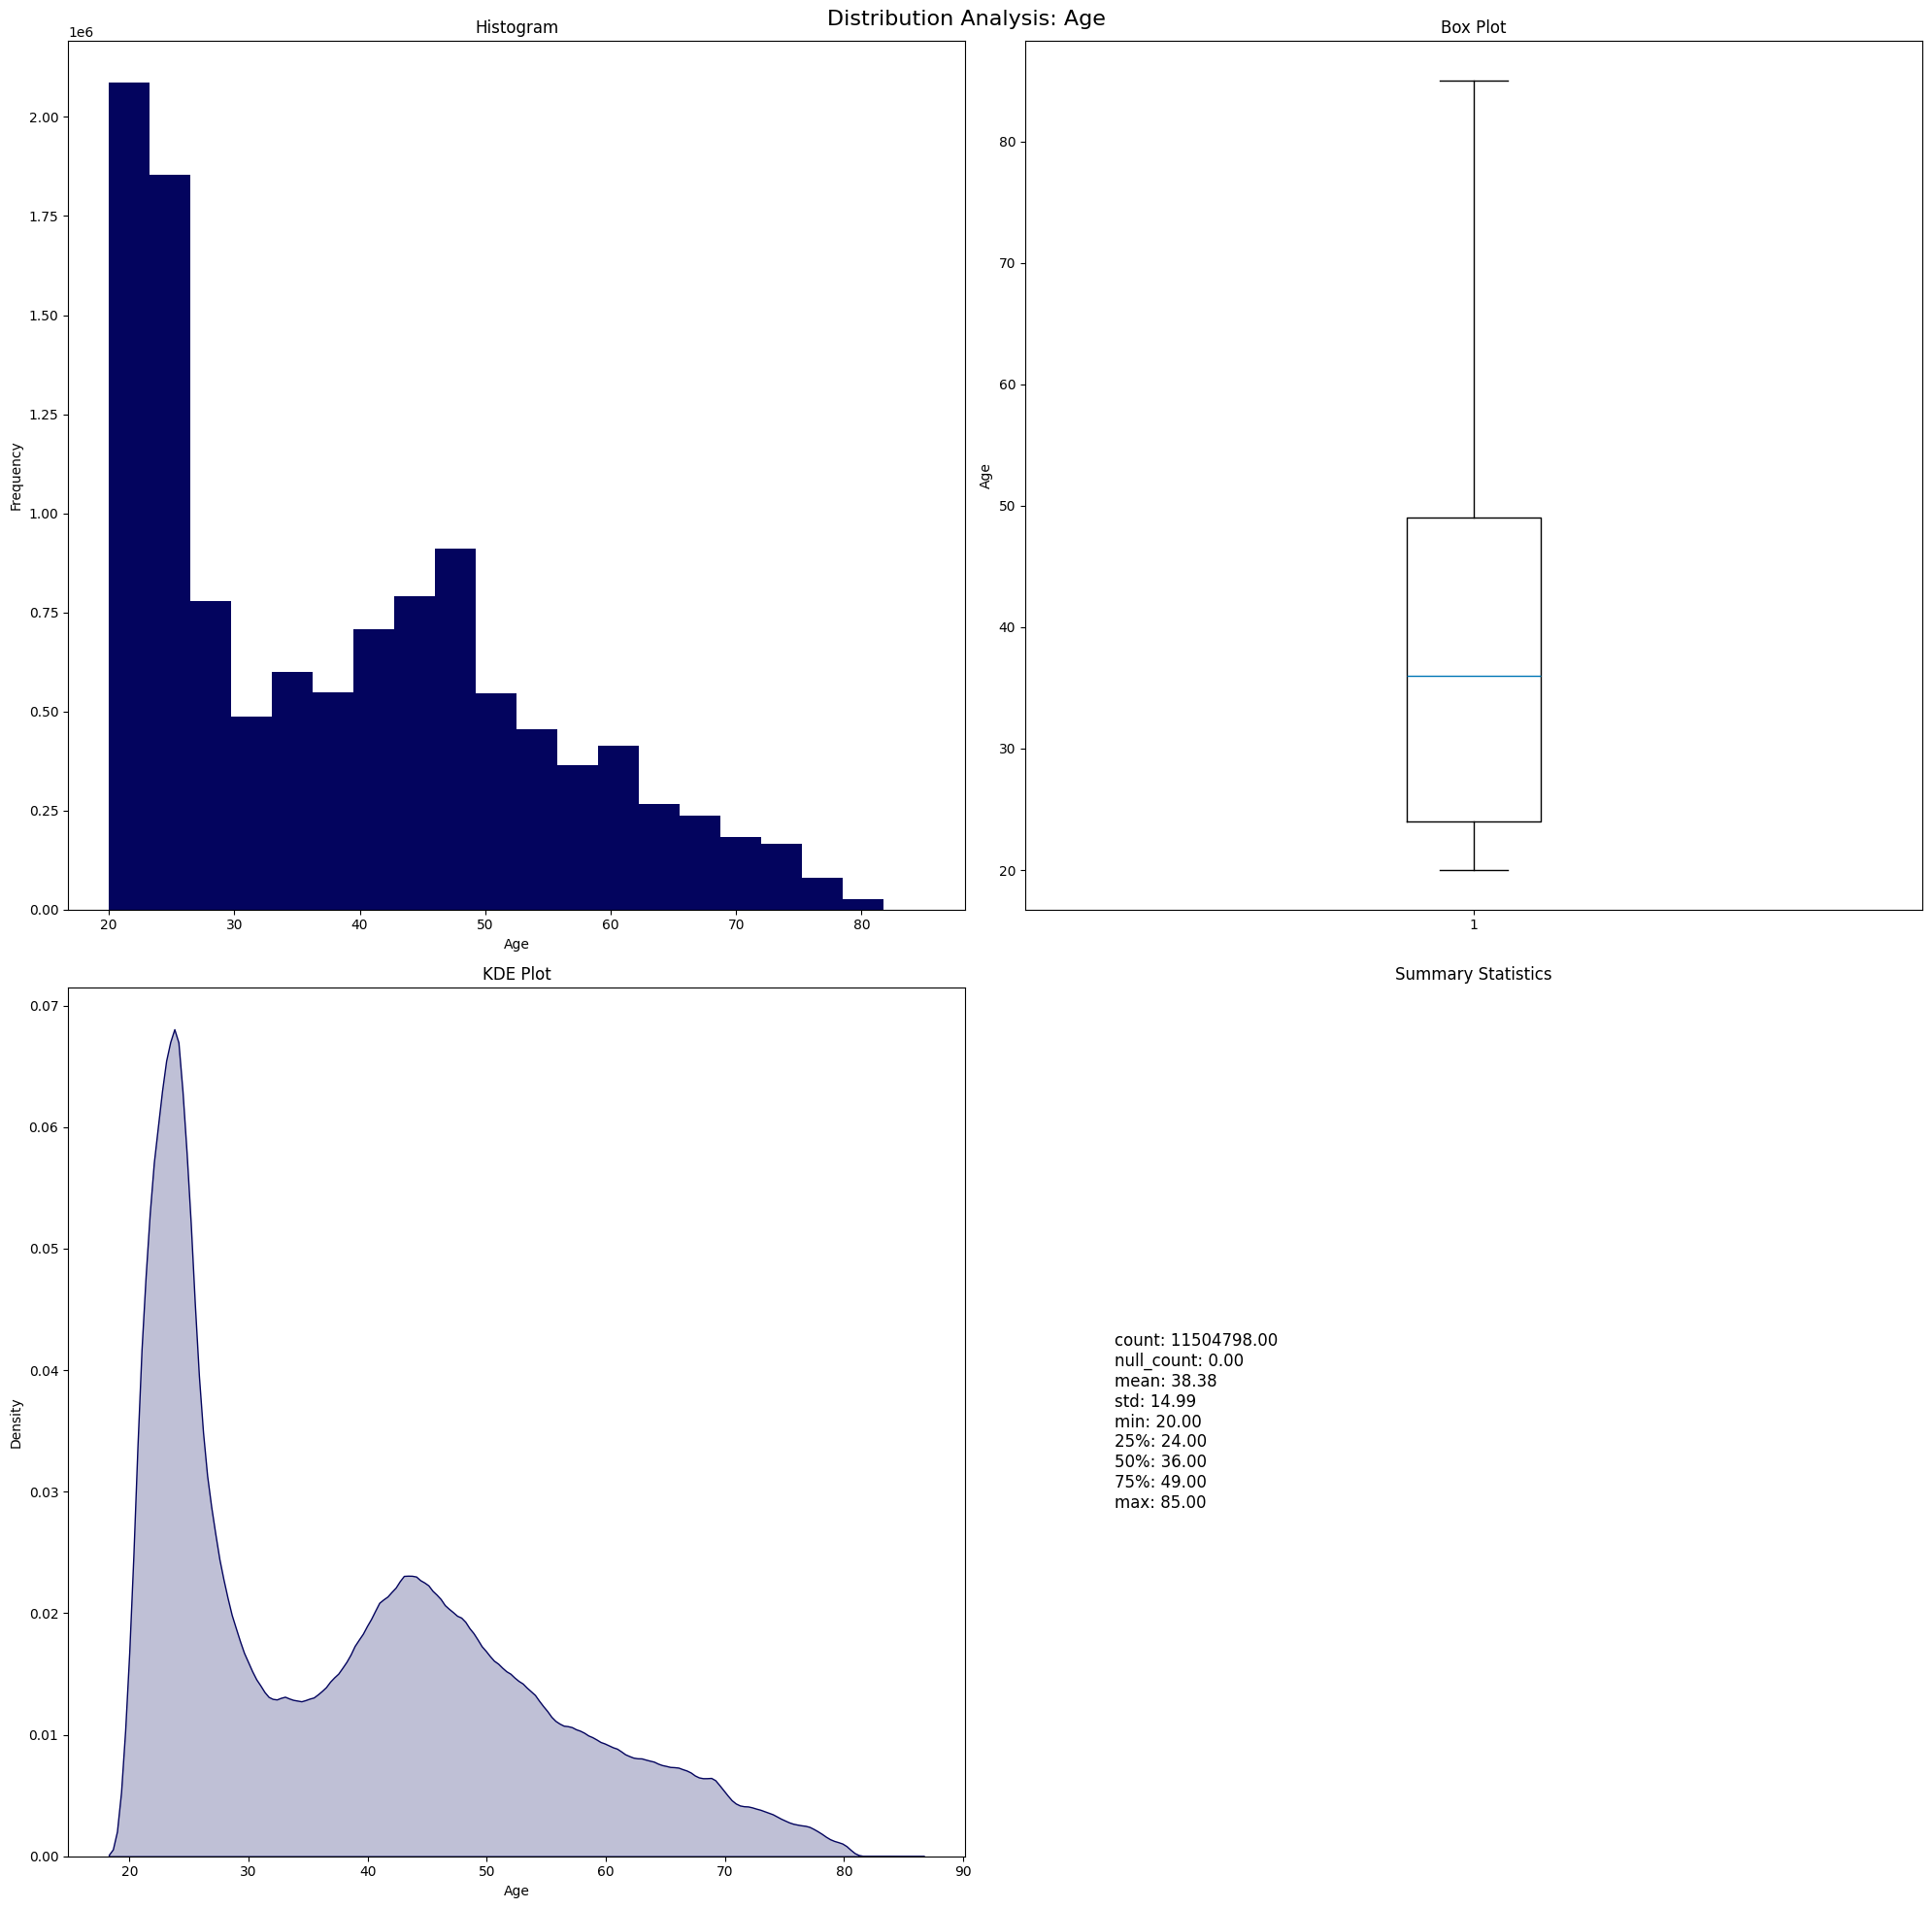

In [9]:
# Displaying general visualizations around the Age feature
if run_visualizations:
    display_continuous_distributions(continuous_feat = df['Age'])

### Feature 4: `Driving_License`
This feature represents whether or not the person has a driver's license. This is a scenario where visuals can be a bit tricky. Looking at the visualizations, we see that there is a large imbalance between those who do and don't have licenses, but interestingly, we see a roughly equal distribution of people who are responding favorably to the cross-sell regardless if they have a driver's license.

To take the analysis a step further, we calculate a **chi-squared test for independence**. This test will help us to determine if there is a strong statistical correlation between this feature and the target class, and as you'll see below, there is indeed a strong association.

**Feature Engineering Plans**:
- Keep the `Driving_License` feature as is.

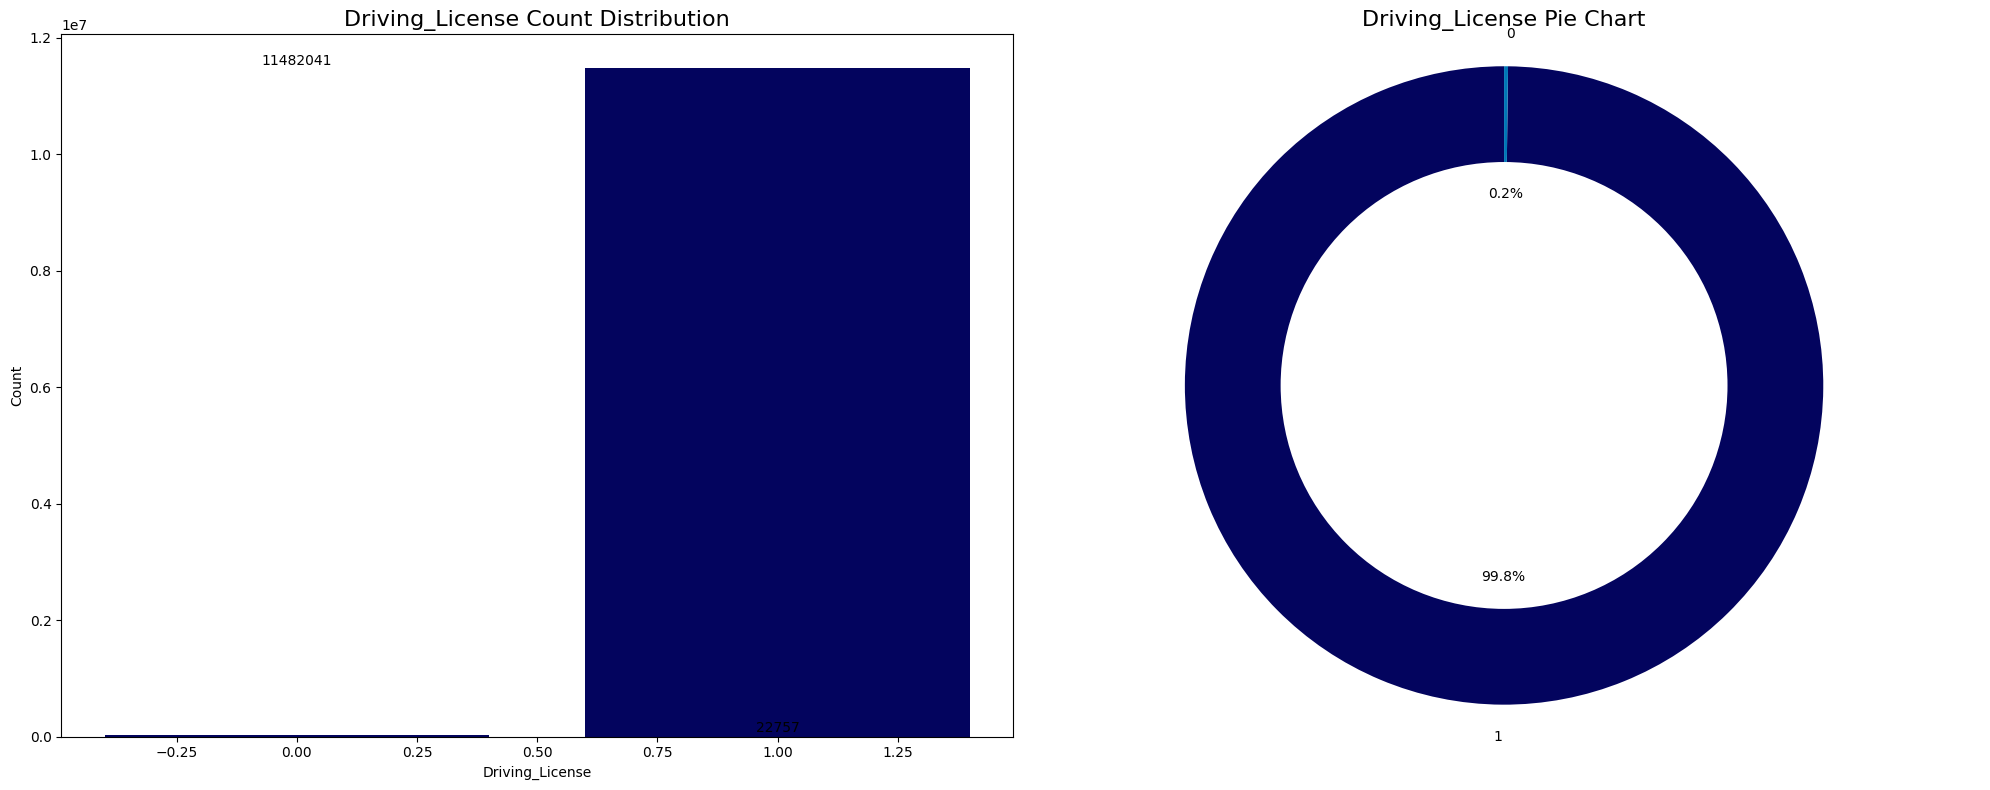

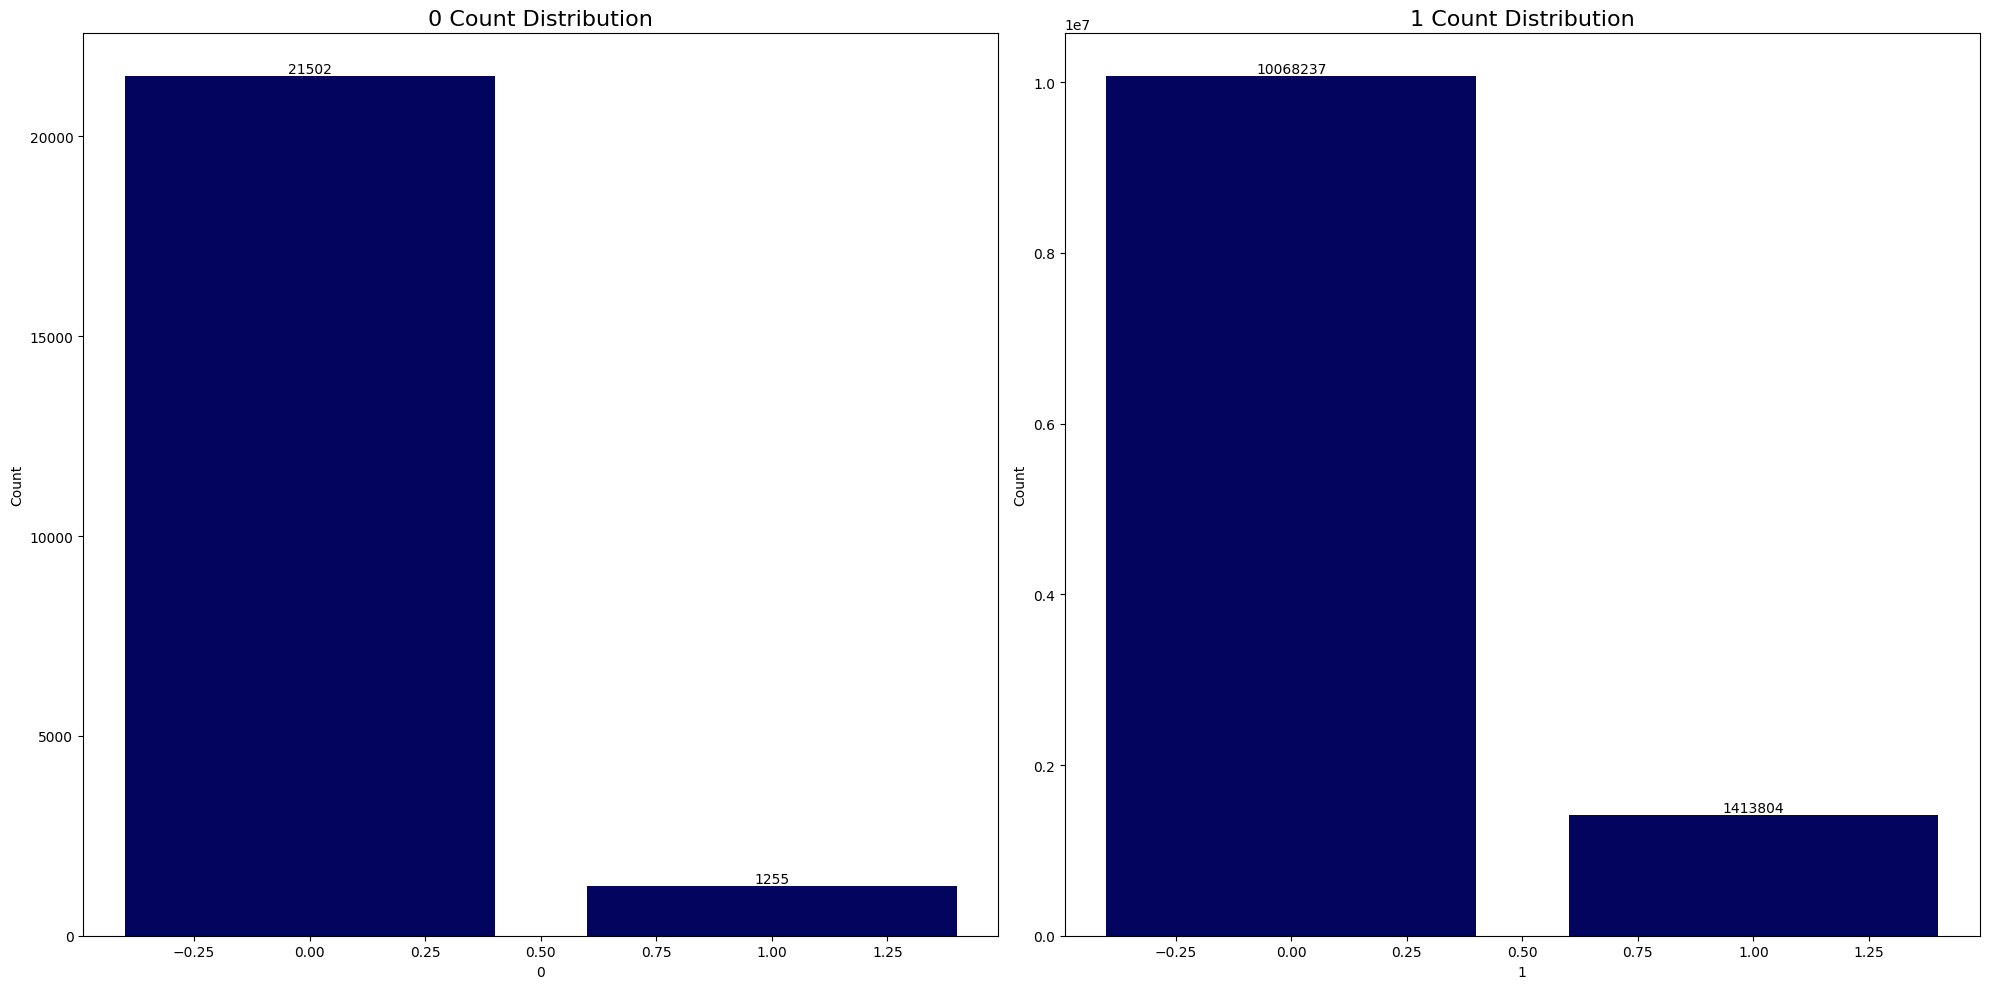

In [10]:
# Displaying general visualizations around the Driving_License feature
if run_visualizations:
    display_binary_counts(binary_feat = df['Driving_License'])
    display_binary_class_to_target_class(
        df = df,
        feat_name = 'Driving_License',
        binary_classes = [0, 1],
        target_class = 'Response'
    )

In [11]:
# Creating a contingency table around Driving_License and Response
contingency_table = (
    df.group_by('Driving_License', 'Response')
    .agg(pl.len().alias('len'))
    .pivot(
        values = 'len',
        index = 'Driving_License',
        columns = 'Response'
    )
    .fill_null(0)
)

# Converting to numpy array for Chi-square
contingency_array = contingency_table.select(pl.exclude('Driving_License')).to_numpy()

# Performing the Chi-square test
chi2, p_value, deg_of_freedom, expected = chi2_contingency(contingency_array)
print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p_value}")
print(f"Degrees of freedom: {deg_of_freedom}")
print("\nContingency table:")
print(contingency_table)
print("\nExpected frequencies:")
print(expected)

# Interpreting the Chi-square results
alpha = 0.05
if p_value <= alpha:
    print(f"\nReject the null hypothesis (p-value: {p_value:.4f} <= {alpha})")
    print("There is a significant relationship between the feature and the target.")
else:
    print(f"\nFail to reject the null hypothesis (p-value: {p_value:.4f} > {alpha})")
    print("There is no significant evidence of a relationship between the feature and the target.")

Chi-square statistic: 972.499672088707
p-value: 1.7058045796900096e-213
Degrees of freedom: 1

Contingency table:
shape: (2, 3)
┌─────────────────┬─────────┬──────────┐
│ Driving_License ┆ 1       ┆ 0        │
│ ---             ┆ ---     ┆ ---      │
│ i64             ┆ u32     ┆ u32      │
╞═════════════════╪═════════╪══════════╡
│ 0               ┆ 1255    ┆ 21502    │
│ 1               ┆ 1413804 ┆ 10068237 │
└─────────────────┴─────────┴──────────┘

Expected frequencies:
[[2.79904938e+03 1.99579506e+04]
 [1.41225995e+06 1.00697810e+07]]

Reject the null hypothesis (p-value: 0.0000 <= 0.05)
There is a significant relationship between the feature and the target.


/var/folders/5q/0hckk7812vs4m11jprtzff600000gn/T/ipykernel_5488/2997149360.py:5: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  .pivot(


### Feature 5: `Region_Code`
This feature represents the region that the customer resides in. We don't have any additional geographic information. There are 54 different regions, but there is a wide range in the distribution by region. Fortunately, a treemap helps us to effectively visualize where the most representation is. As such, we gain the following insights:

- Around 1/3 of the records fall within the specific `28.0` region code
- Around 1/3 of the records fall within the next 7 highest categories after the `28.0` region code
- The last 1/3 of records are represented by the remaining multitude of classes (around 50 of them)

**Feature Engineering Plans**:
- One hot encode the `Region_Code` after binning into three specific tiers:
    - Tier 1: All records in the `28.0` region code, which is the most represented region code
    - Tier 2: Any record in the following following top 7 represented categories after the `28.0` region code
    - Tier 3: All other records that do not fall in either tier above

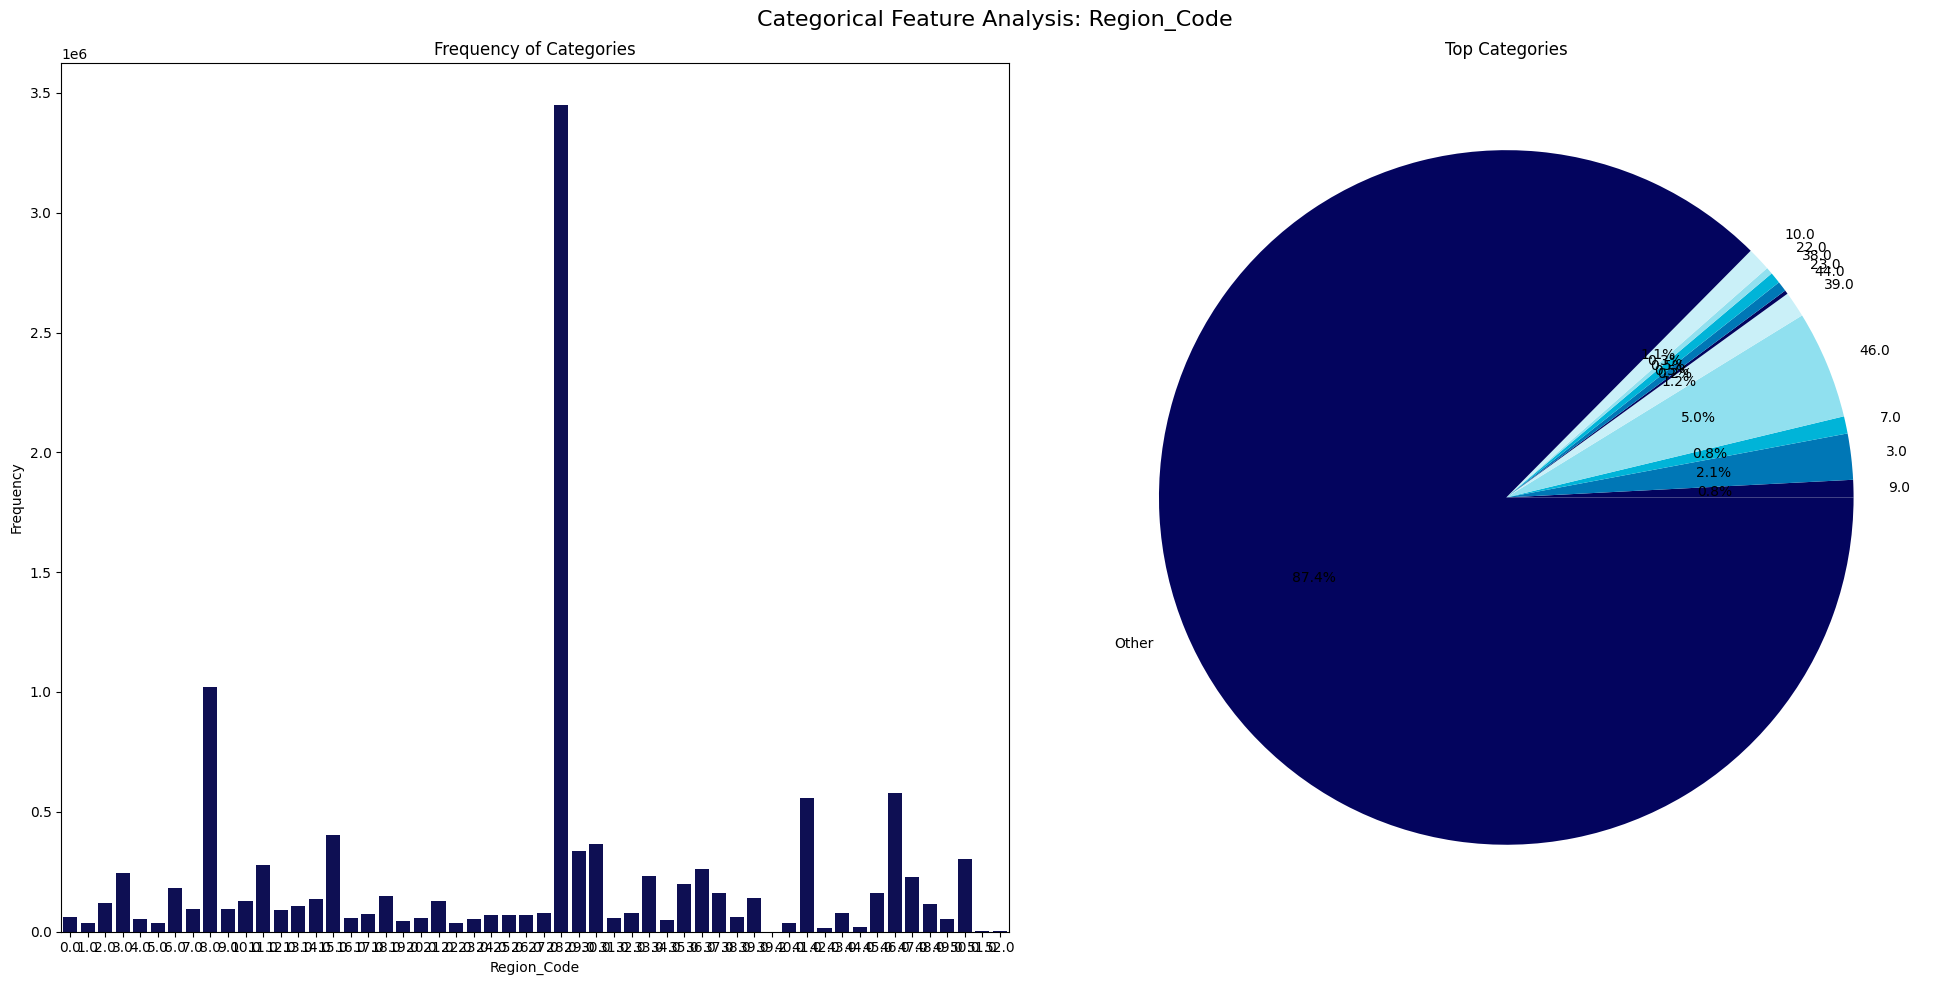

In [12]:
# Displaying general visualizations around the Region_Code feature
if run_visualizations:
    display_categorical_visualizations(cat_feat = df['Region_Code'])

### Feature 6: `Previously_Insured`
In my opinion, the name of this feature is a bit misleading. Per a link above, we can read to learn that `Previously_Insured` actually *indicates if somebody already has auto insurance*. I'm tempted to rename this to `Already_Insured`, but I don't want to confuse future readers! 😅

As you can expect, there are very few positive cases in the target class for any customer who already has auto insurance. I'm a bit surprised this number isn't zero, but perhaps this indicates a cross sell to something like a boat 🚤.

I would want to know more of a business context around this. As I note above, I'm suspiciously curious how few positive cases there were for a customer who already had auto insurance. In my mind, it doesn't seem like you'd want to market to those people at all. In that case, what I would actually do is this: **I would take this feature out of the predictive inference model and use it as a hard Boolean gate: If you're already insured, we're going to return an automatic "no", no need to fuss around with the model.**

For the purposes of this competition, I can't really make any strong assumptions, so I'm going to keep this feature around regardless of the paragraph above.

**Feature Engineering Plans:**
- Keep `Previously_Insured` feature as is.


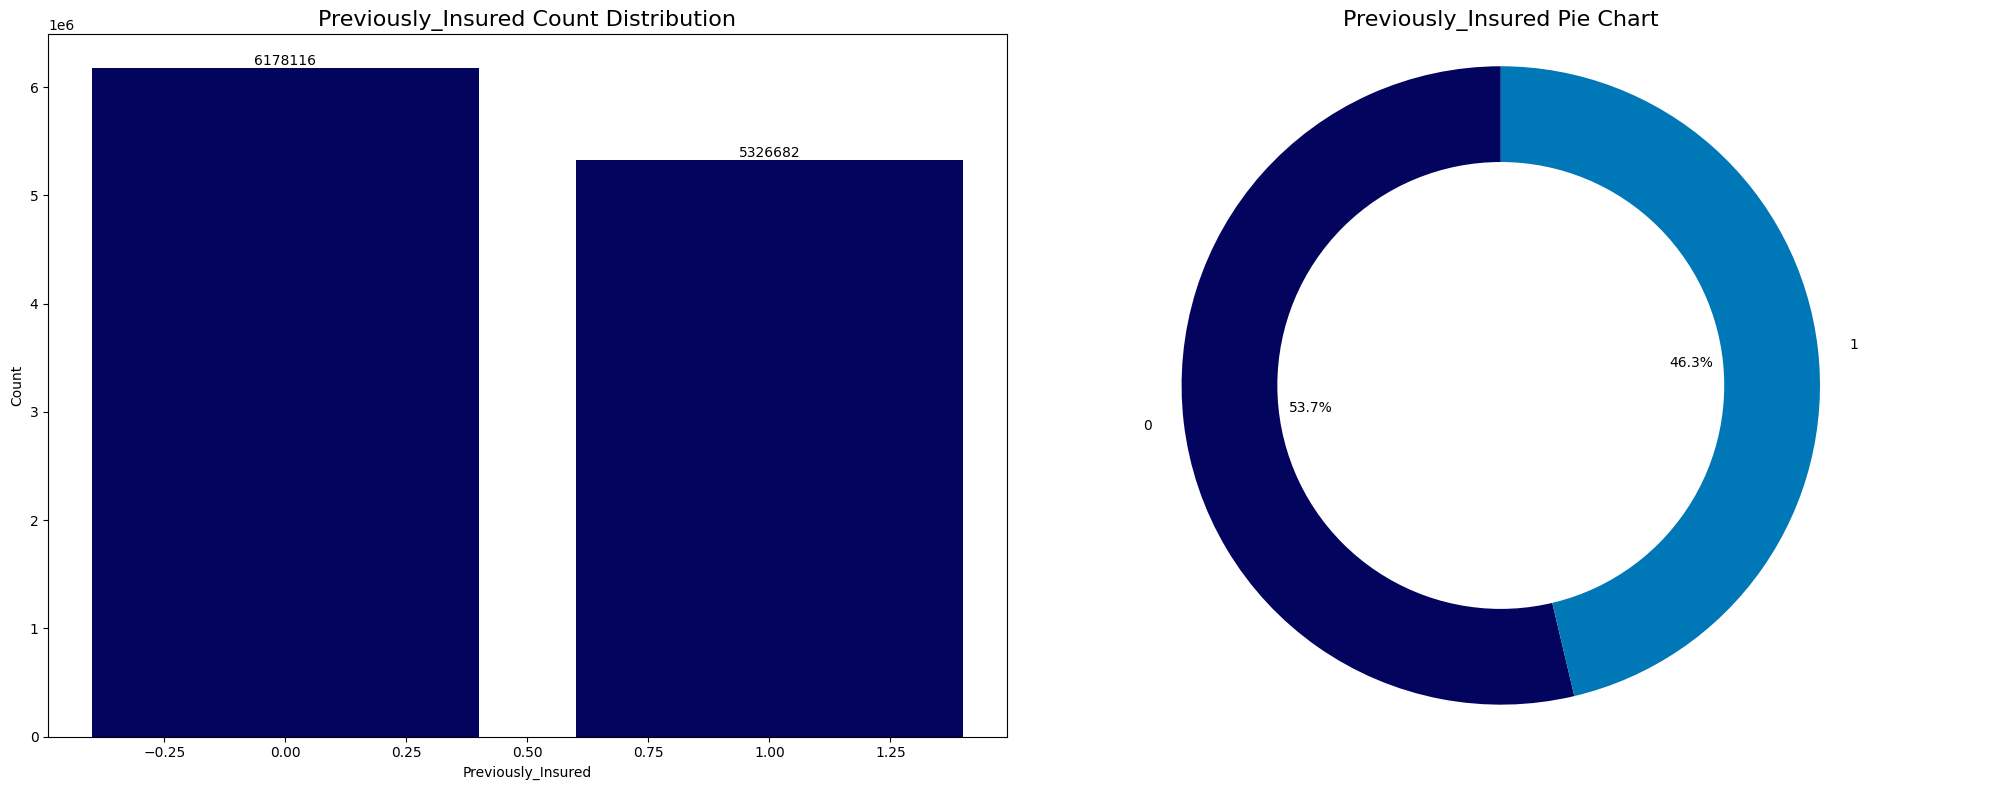

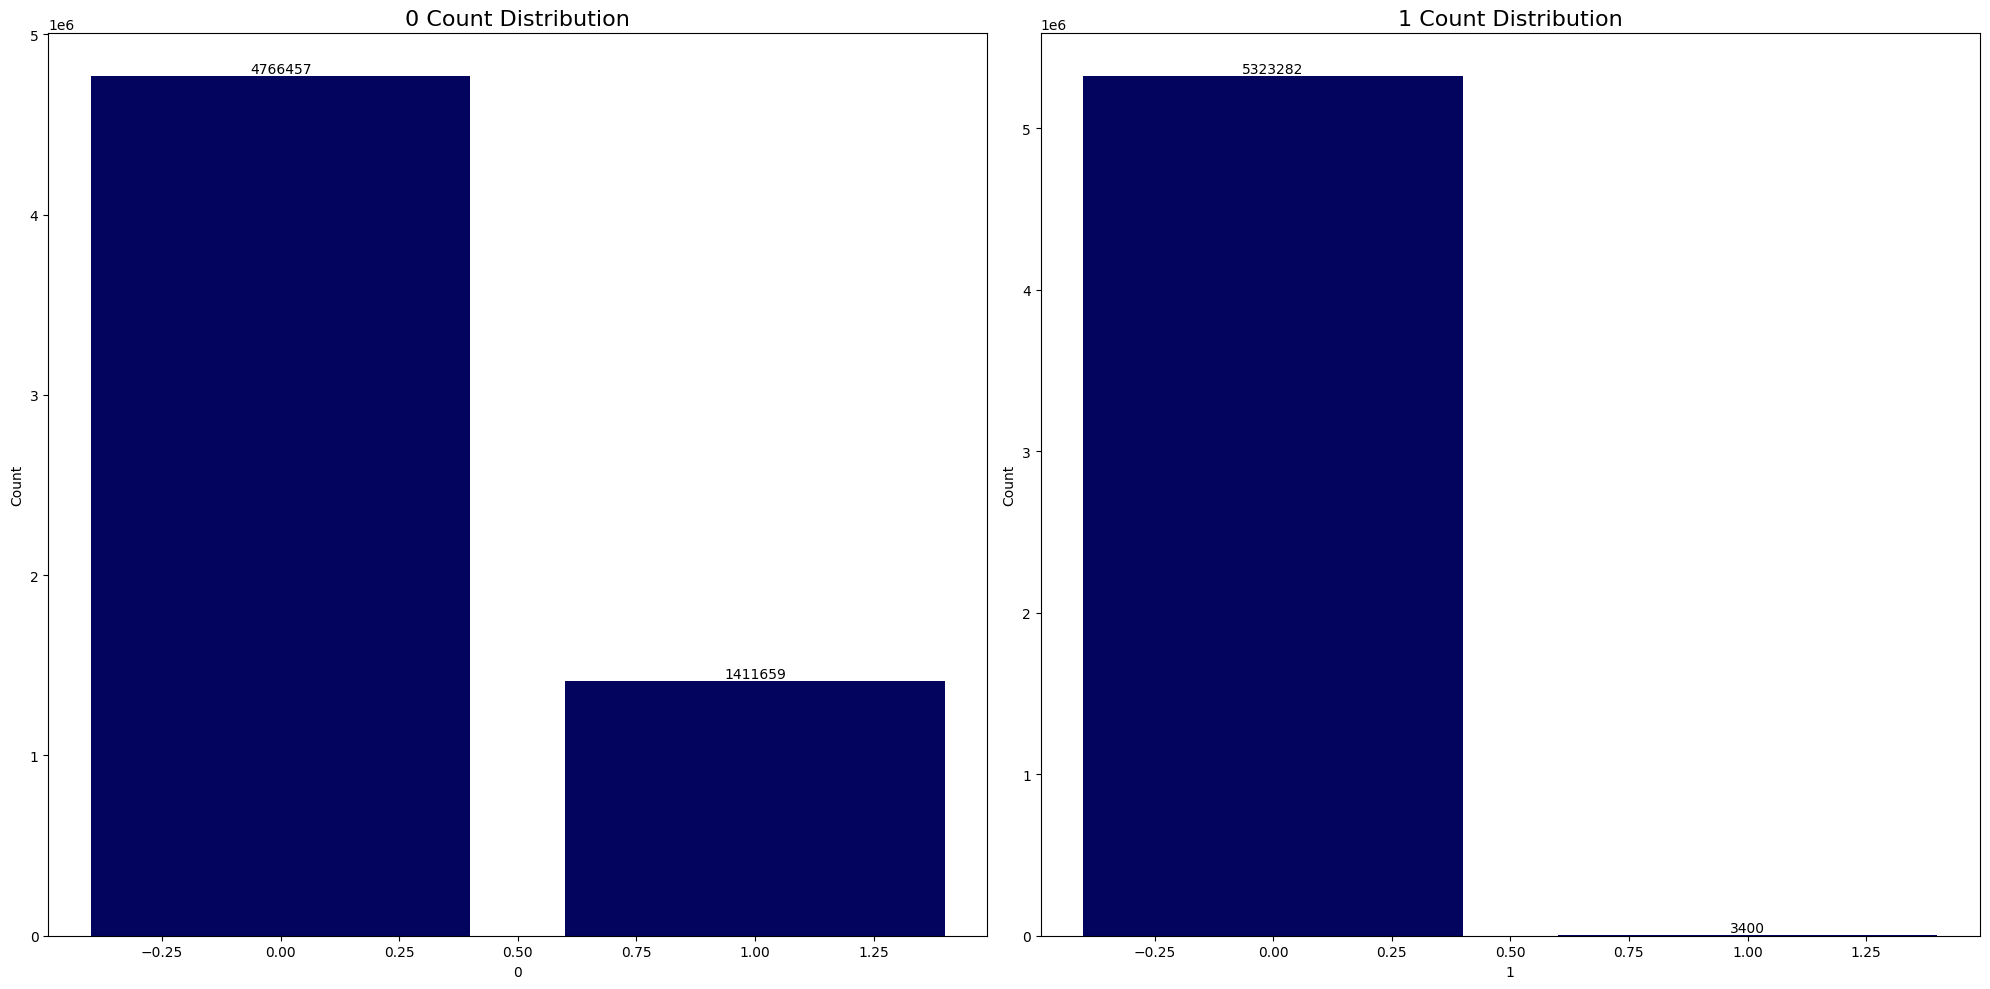

In [13]:
# Displaying general visualizations around the Previously_Insured feature
if run_visualizations:
    display_binary_counts(binary_feat = df['Previously_Insured'])
    display_binary_class_to_target_class(
        df = df,
        feat_name = 'Previously_Insured',
        binary_classes = [0, 1],
        target_class = 'Response'
    )

### Feature 7: `Vehicle_Age`
While this feature is called `Vehicle_Age`, we're not given this information in a continuous form as we might typically expect. Instead, this is a categorical feature with only 3 categories. Two of these categories are more represented than the others.

**Feature Engineering Plans**:
- One hot encode the `Vehicle_Age` feature.

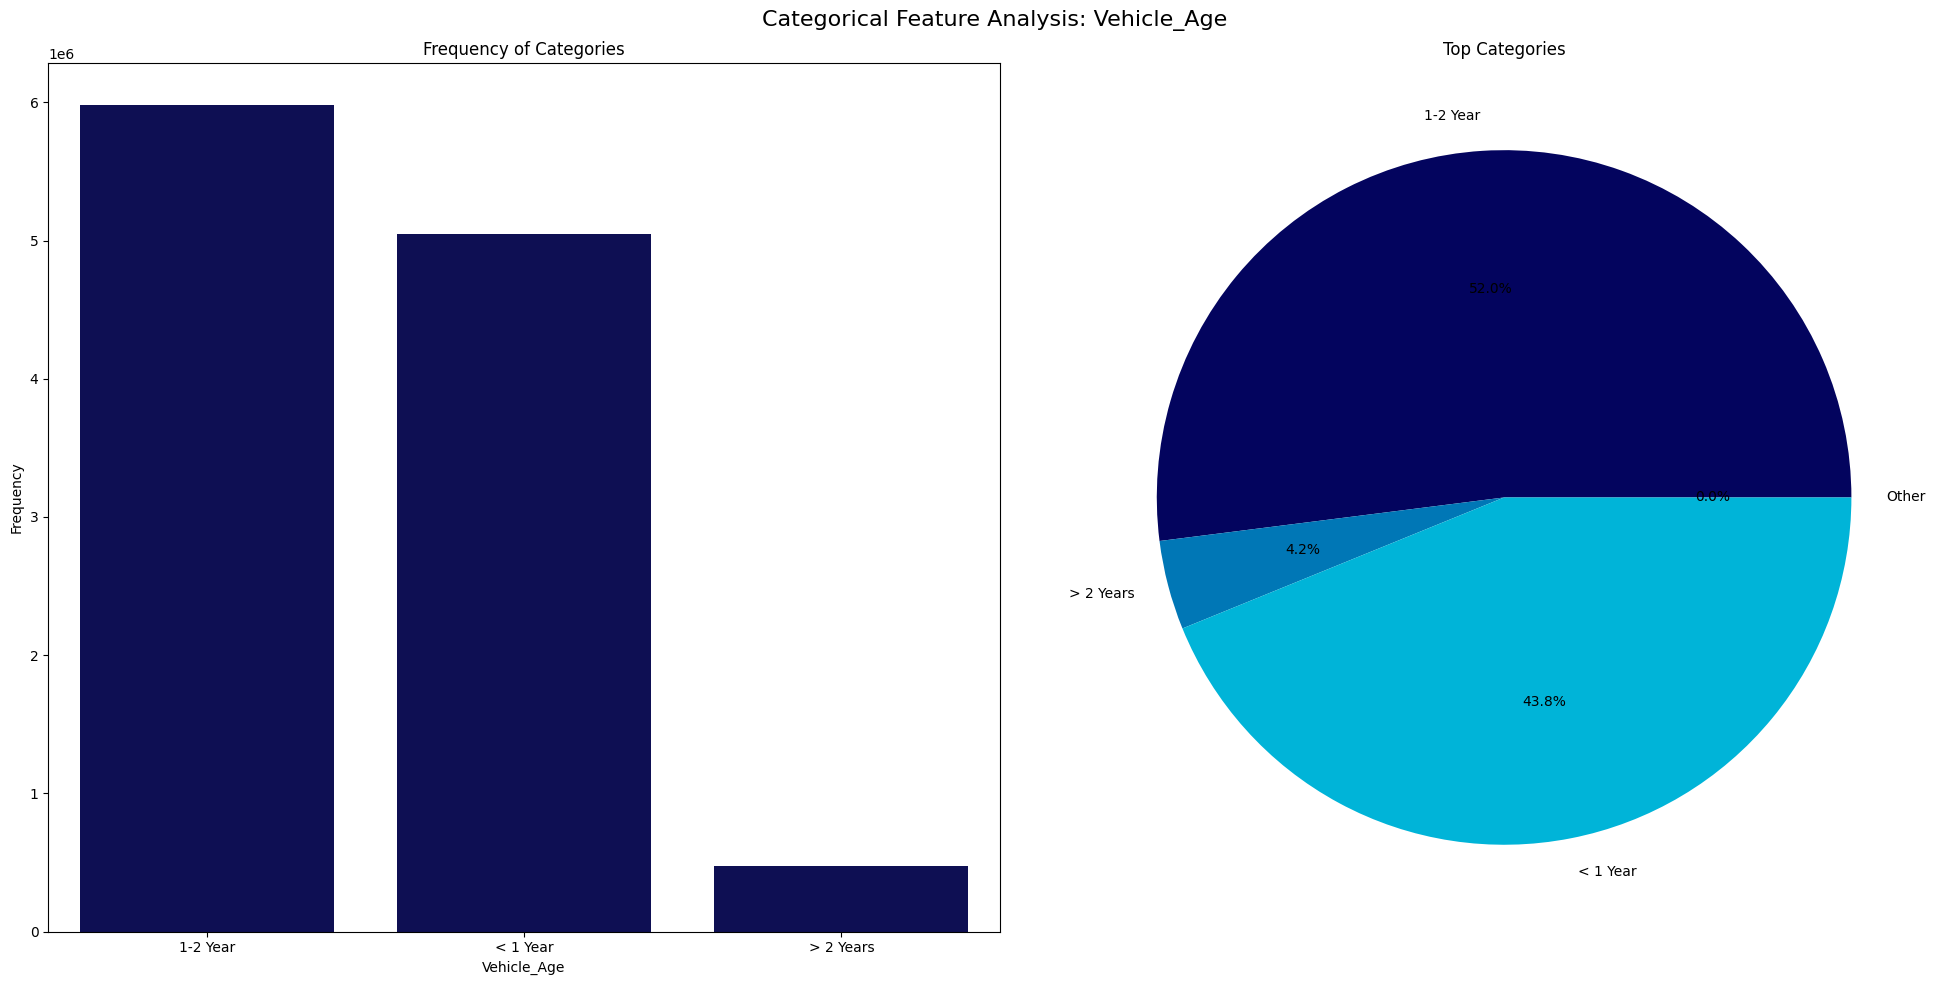

In [14]:
# Displaying general visualizations around the Vehicle_Age feature
if run_visualizations:
    display_categorical_visualizations(cat_feat = df['Vehicle_Age'])

### Feature 8: `Vehicle_Damage`
As the name indicates, this feature represents if a customer's vehicle has experienced damage in the past. This feature is similar to the `Previously_Insured` feature, where almost all respondants to the target variable are people who have a history of vehicle damage.

**Feature Engineering Plans:**:
- Numerically encode the `Vehicle_Damage` feature

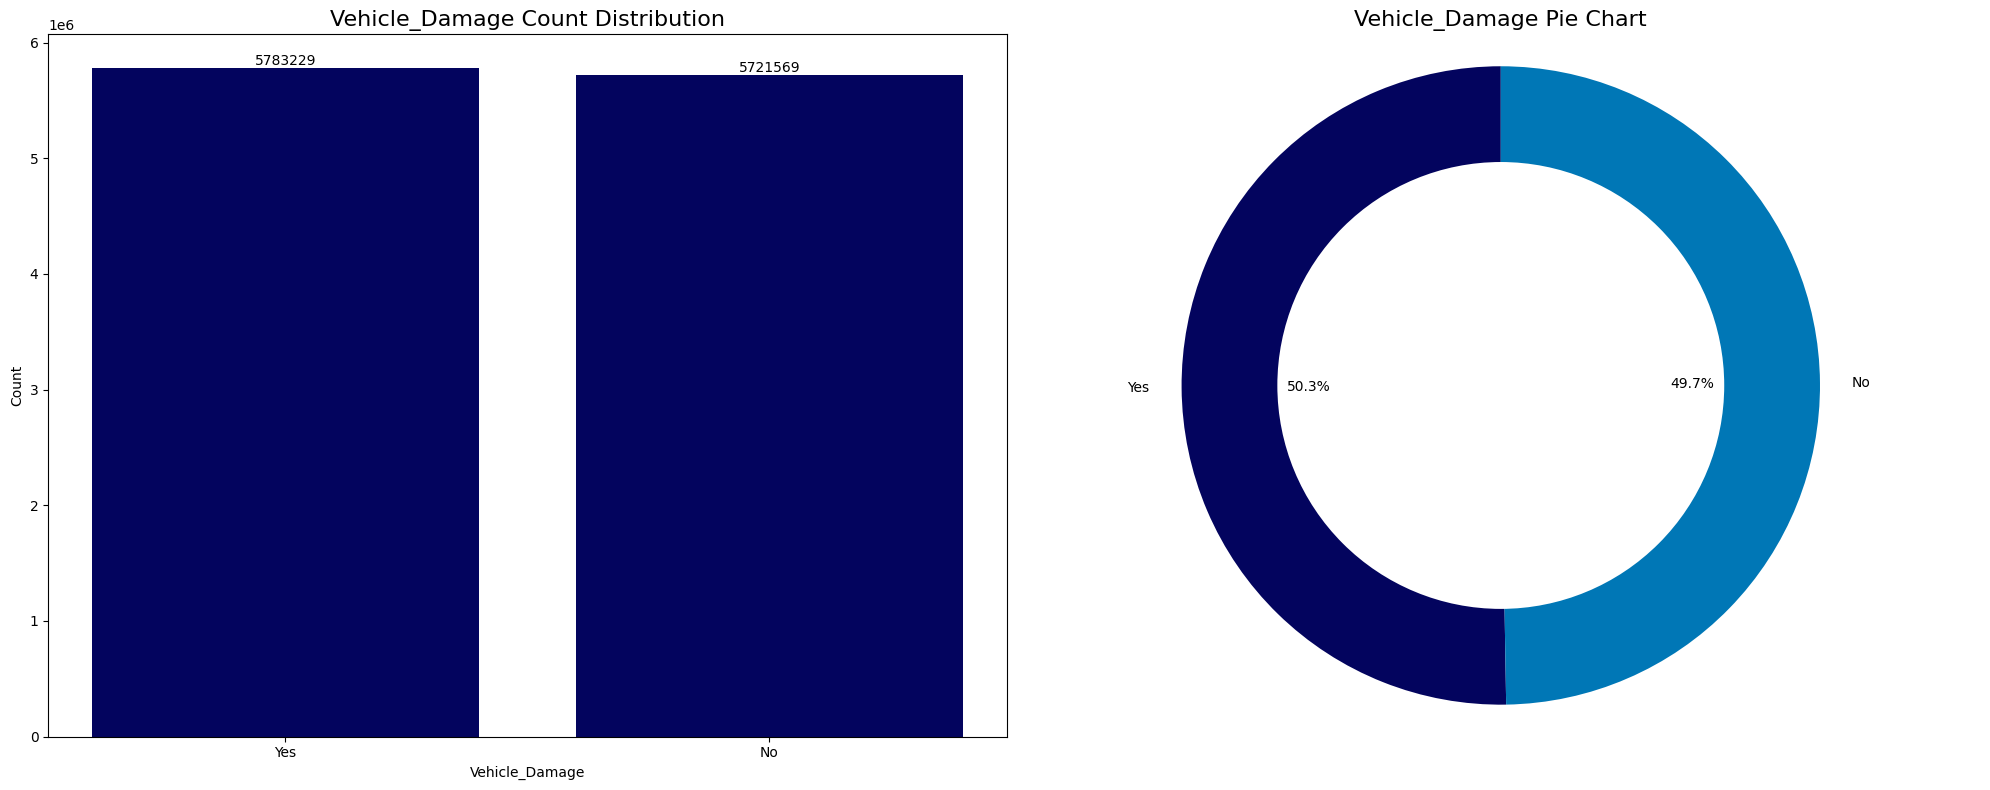

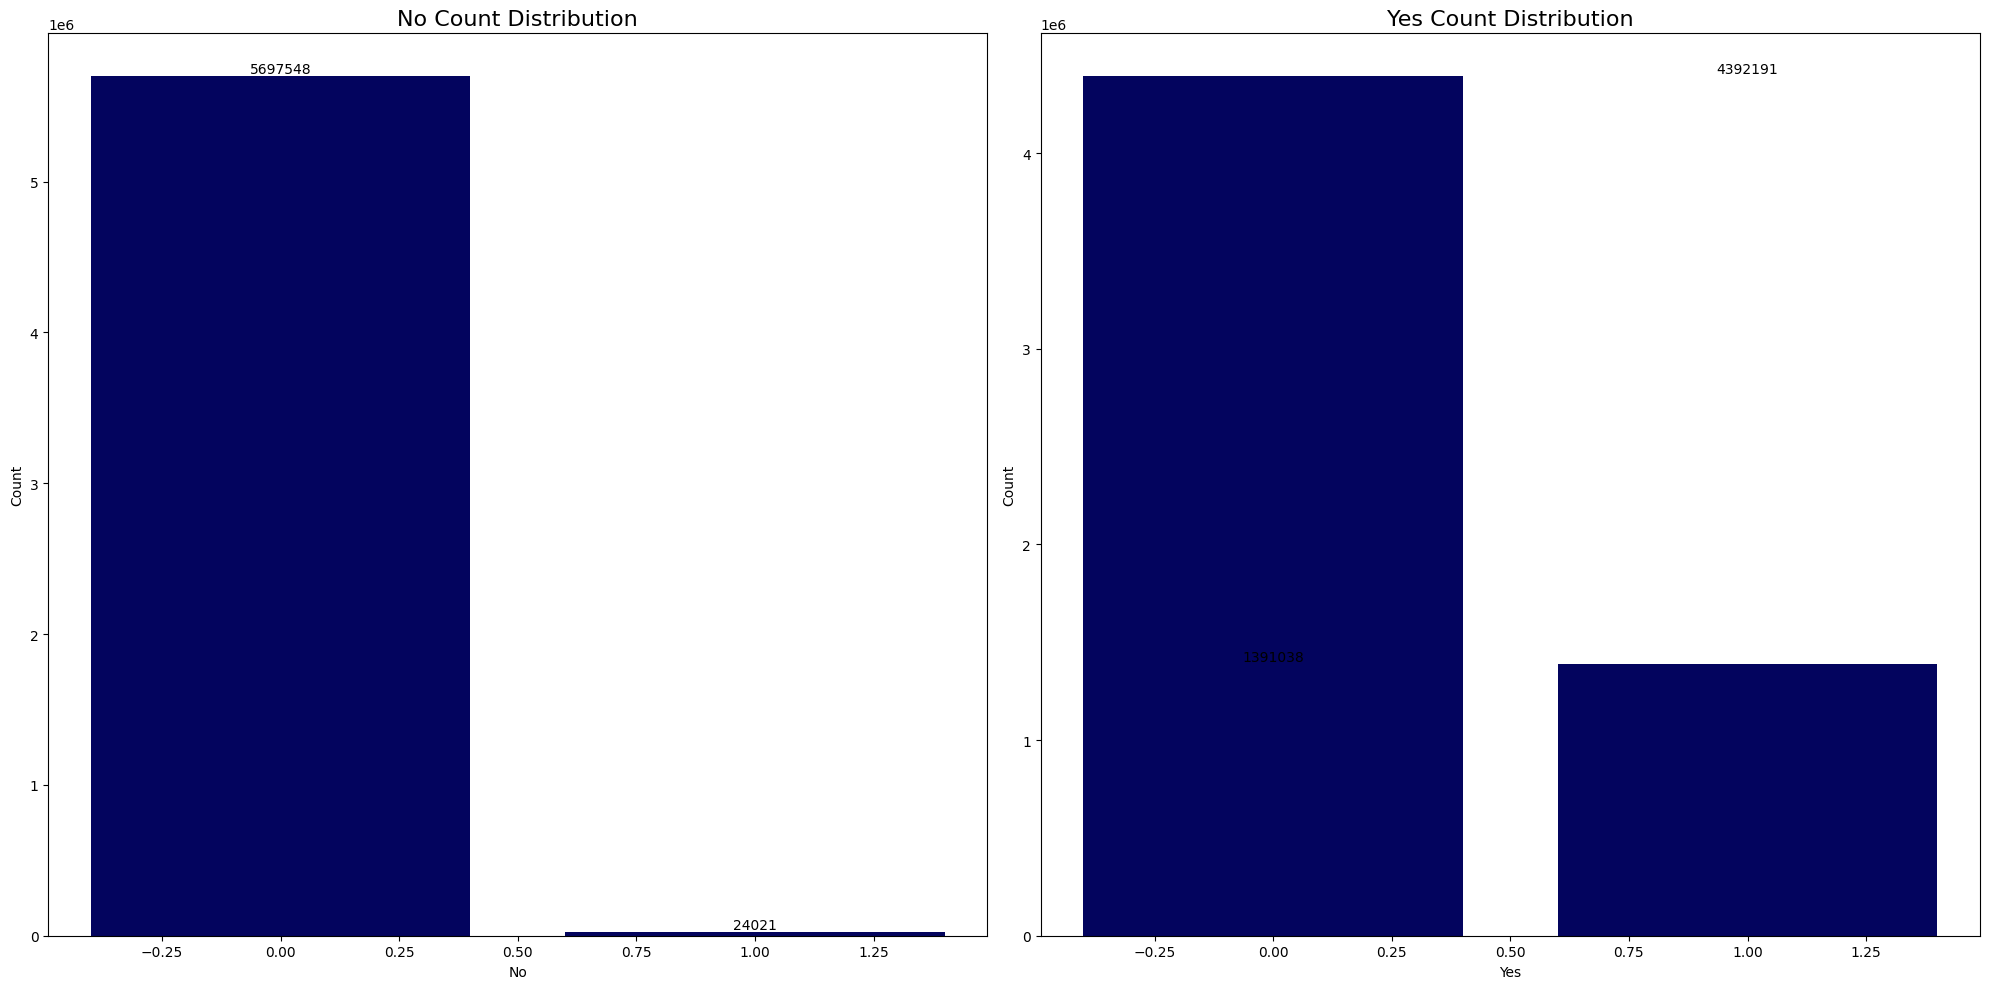

In [15]:
# Displaying general visualizations around the Vehicle_Damage feature
if run_visualizations:
    display_binary_counts(binary_feat = df['Vehicle_Damage'])
    display_binary_class_to_target_class(
        df = df,
        feat_name = 'Vehicle_Damage',
        binary_classes = ['No', 'Yes'],
        target_class = 'Response'
    )

### Feature 9: `Annual_Premium`
This is a continuous feature that represents the annual premium currently paid by a customer. As you can see by the initial set of visualizations below, this data is extremely skewed to the right. The initial box plot indicates that the IQR is relatively narrow when compared to the full range of the native feature. When drilling down further in the second set of visualizations just looking at the IQR, we can see that the data is arguably normally distributed. Additionally, we do have a bunch of records that one one specific value, 2112561.

**Feature Engineering Plans**:
- Convert the currently continuous `Annual_Premium` feature into a categorical feature with the three following categories:
    - A category referencing the largest class, which is a set value of 2112561,
    - A category representing all the premiums that fall within the IQR
    - A category to catch anything else not represented by the previous two categories

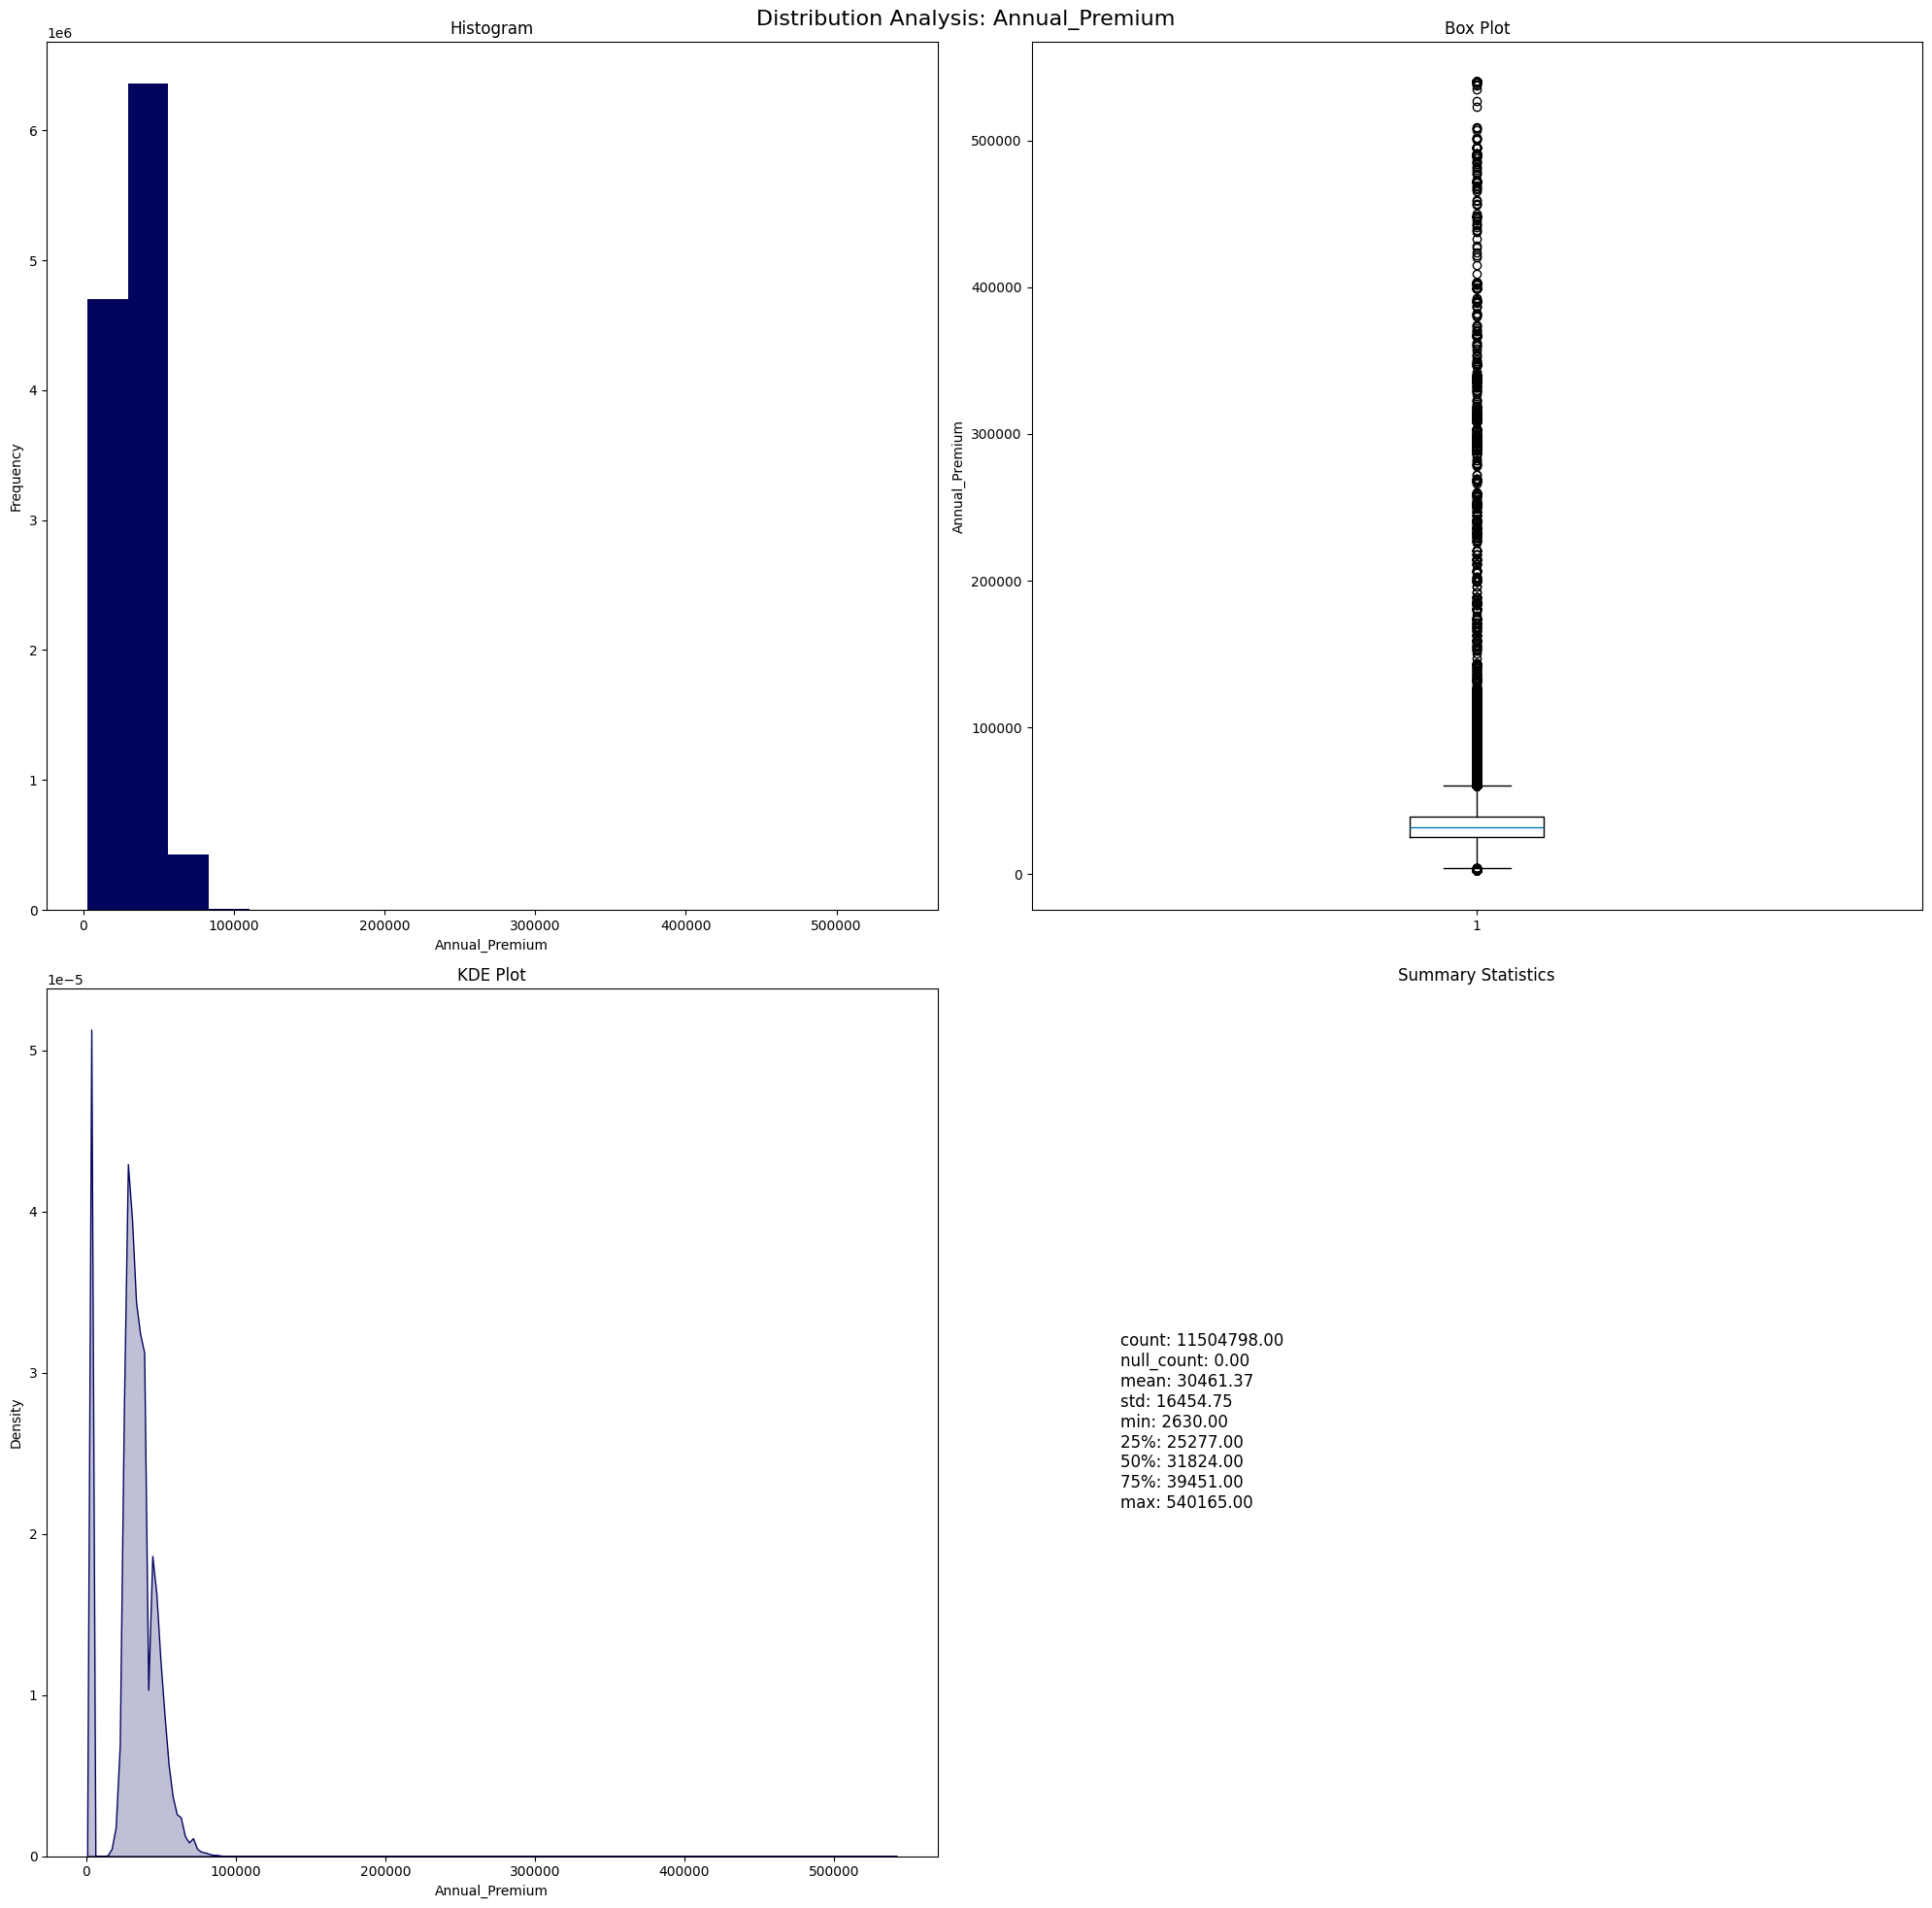

In [16]:
# Displaying general visualizations around the Annual_Premium feature
if run_visualizations:
    display_continuous_distributions(continuous_feat = df['Annual_Premium'])

In [17]:
# Viewing the value counts associated to Annual Premium
df['Annual_Premium'].value_counts().sort(by = 'count', descending = True)

Annual_Premium,count
f64,u32
2630.0,2112561
38287.0,6363
39008.0,5285
38452.0,4721
28861.0,4671
…,…
72137.0,1
63368.0,1
70794.0,1


In [18]:
# Calculating the upper and lower bounds representing IQR for Annual Premium
lower_bound = df['Annual_Premium'].quantile(0.25)
upper_bound = df['Annual_Premium'].quantile(0.75)

# Filtering the data based on the Annual Premium's IQR
filtered_df = df.filter(
    (pl.col('Annual_Premium') >= lower_bound) &
    (pl.col('Annual_Premium') <= upper_bound)
)

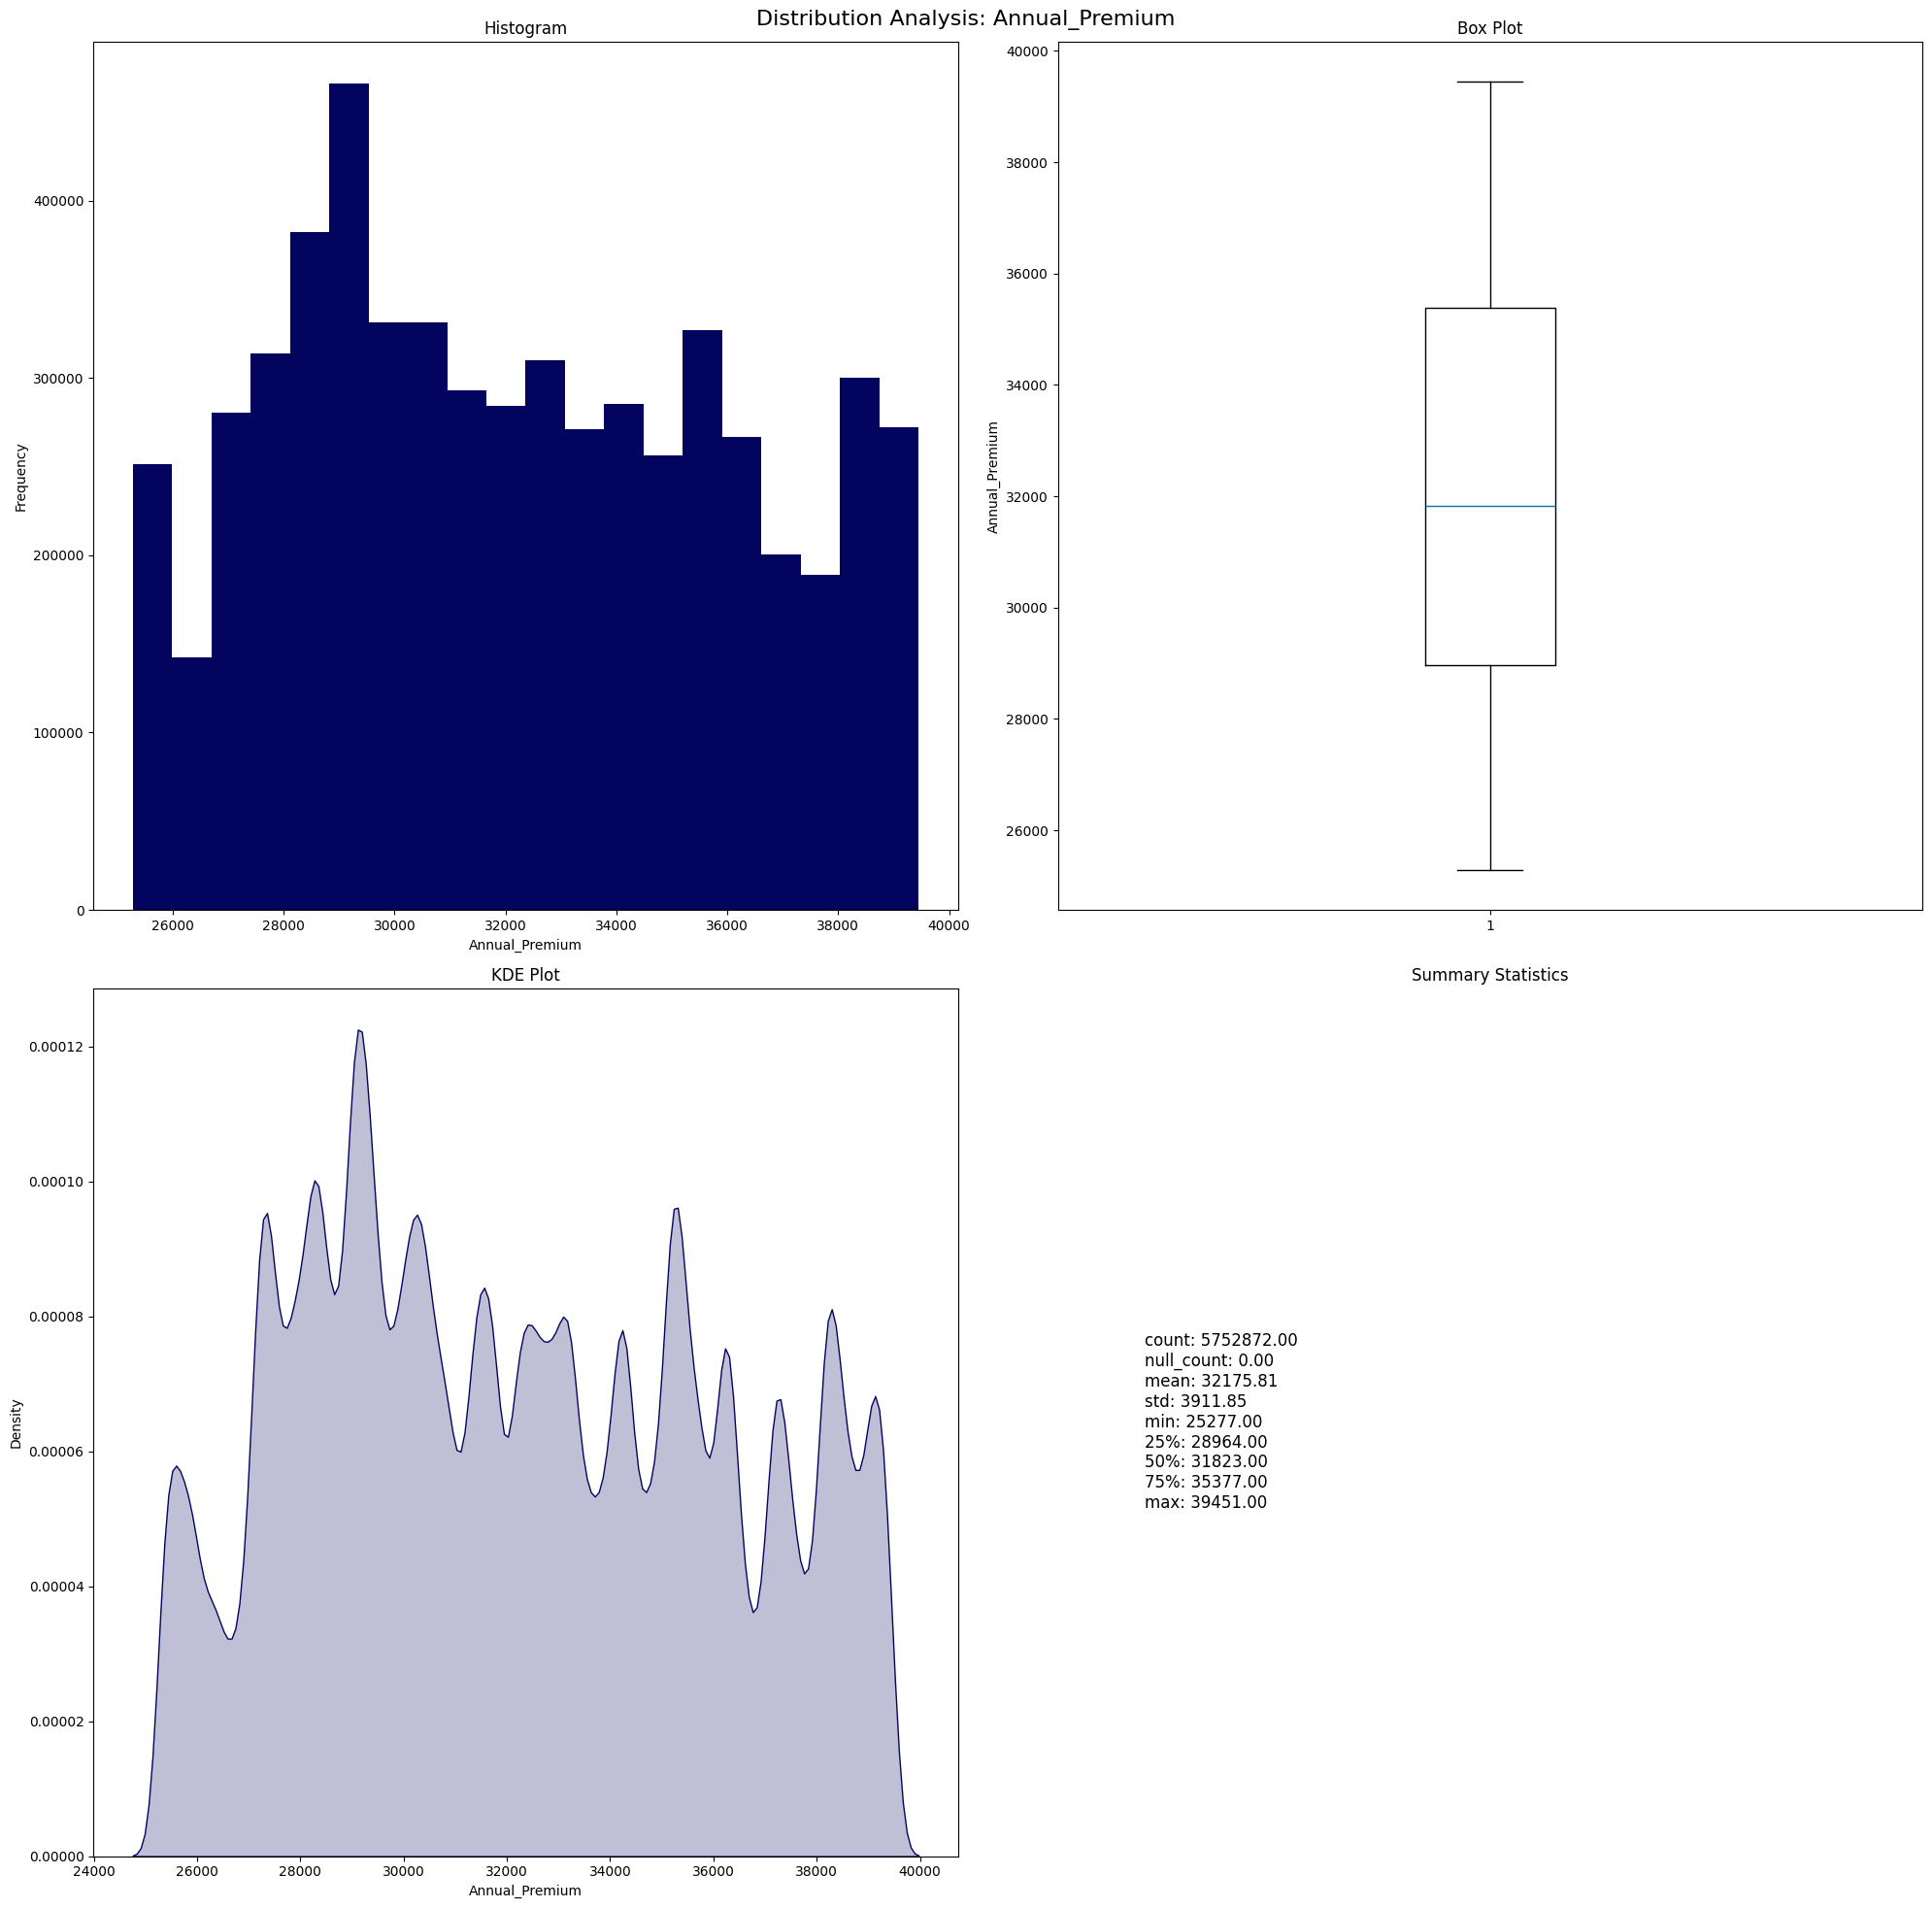

In [19]:
# Displaying general visualizations around the IQR for the Annual_Premium feature
if run_visualizations:
    display_continuous_distributions(continuous_feat = filtered_df['Annual_Premium'])

### Feature 10: `Policy_Sales_Channel`
This feature represents the sales channel that was used to market to the customer. Unfortunately, we don't have a clear picture on what this feature truly represents since this is a categorical feature with anonymized codes to represent the sales channel. Looking at a treemap, however, we can easily tell that there are a few sales channels that greatly outweigh lesser used sales channels.

**Feature Engineering Plans:**
- One hot encode the `Policy_Sales_Channel` feature after binning into four groups, where the first 3 groups represent the largest represented sales channels and the 4th one is a bucket for everything else.

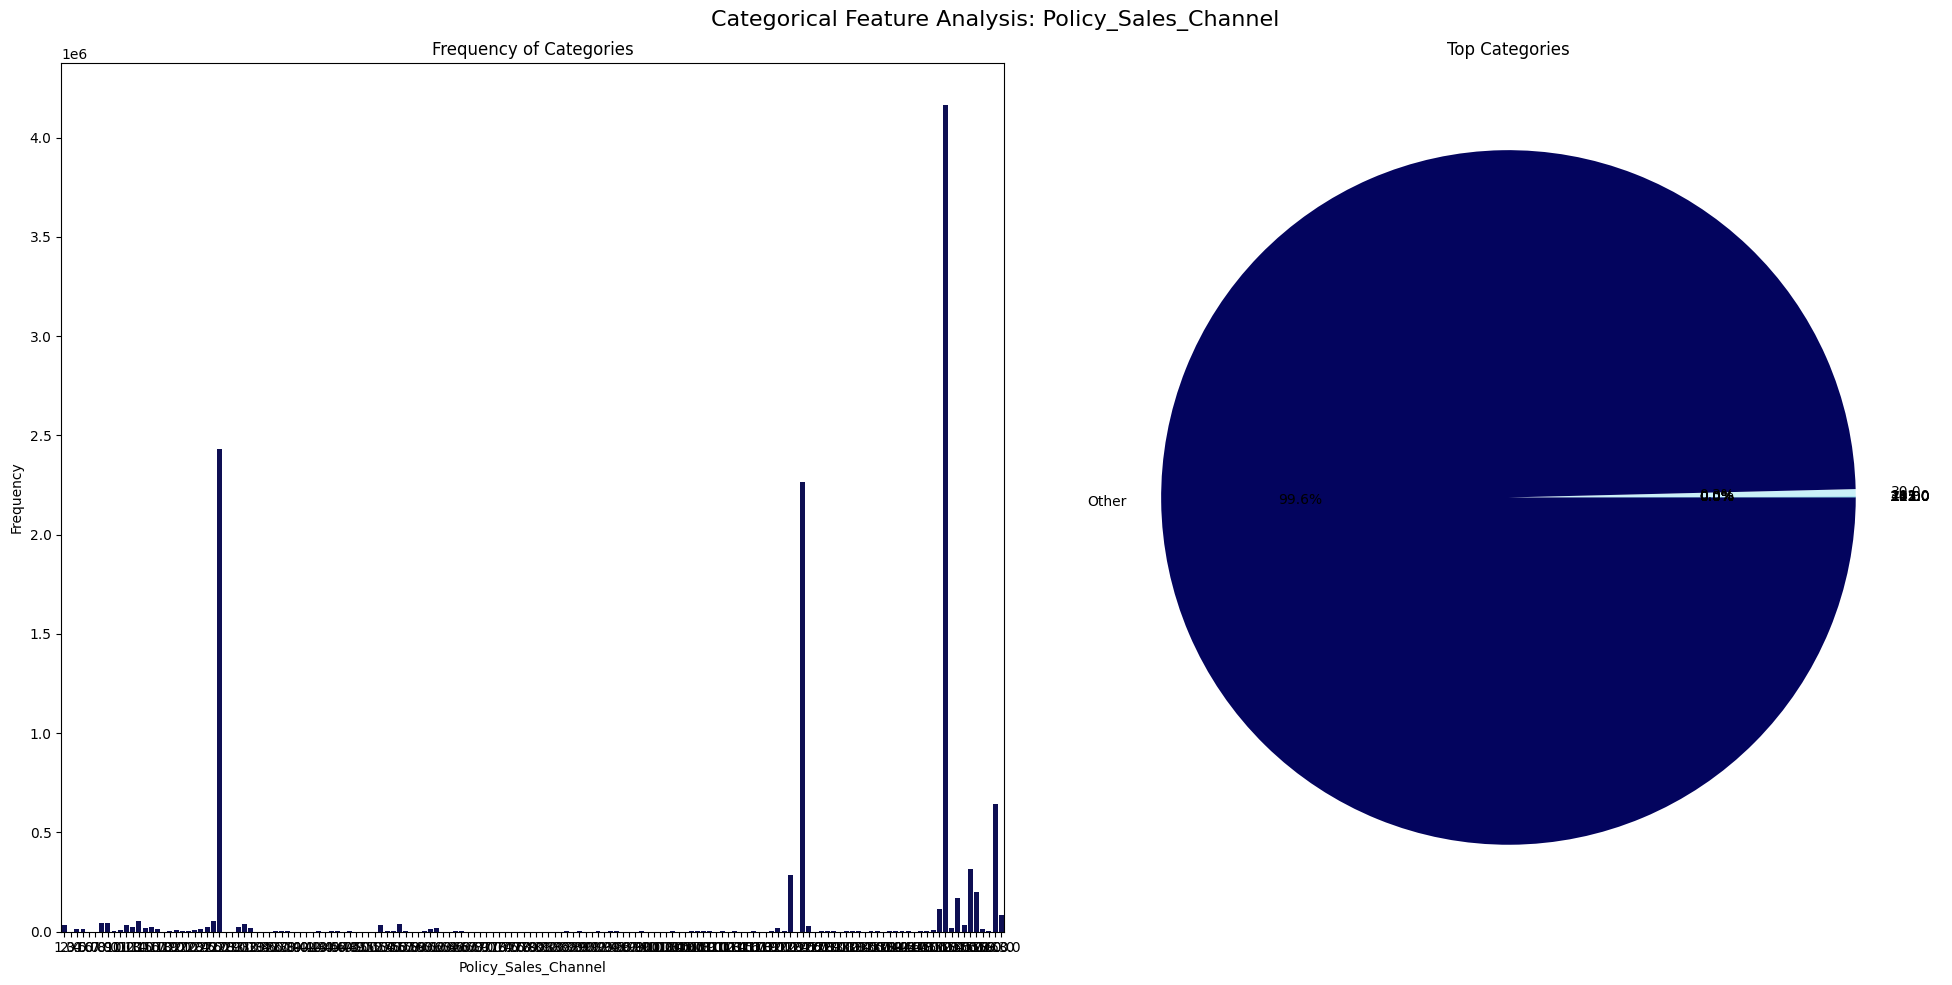

In [20]:
# Displaying general visualizations around the Policy_Sales_Channel feature
if run_visualizations:
    display_categorical_visualizations(cat_feat = df['Policy_Sales_Channel'])

### Feature 11: `Vintage`
This feature is a bit of a misnomer, given that the word "vintage" is generally associated with things, specifically vehicles. In this case, `Vintage` refers to the number of days that a customer has been in business with our insurance company. The data is a bit sporadic, but it is arguably normally distributed.

**Feature Engineering Plans:**
- Keep the `Vintage` feature as is.

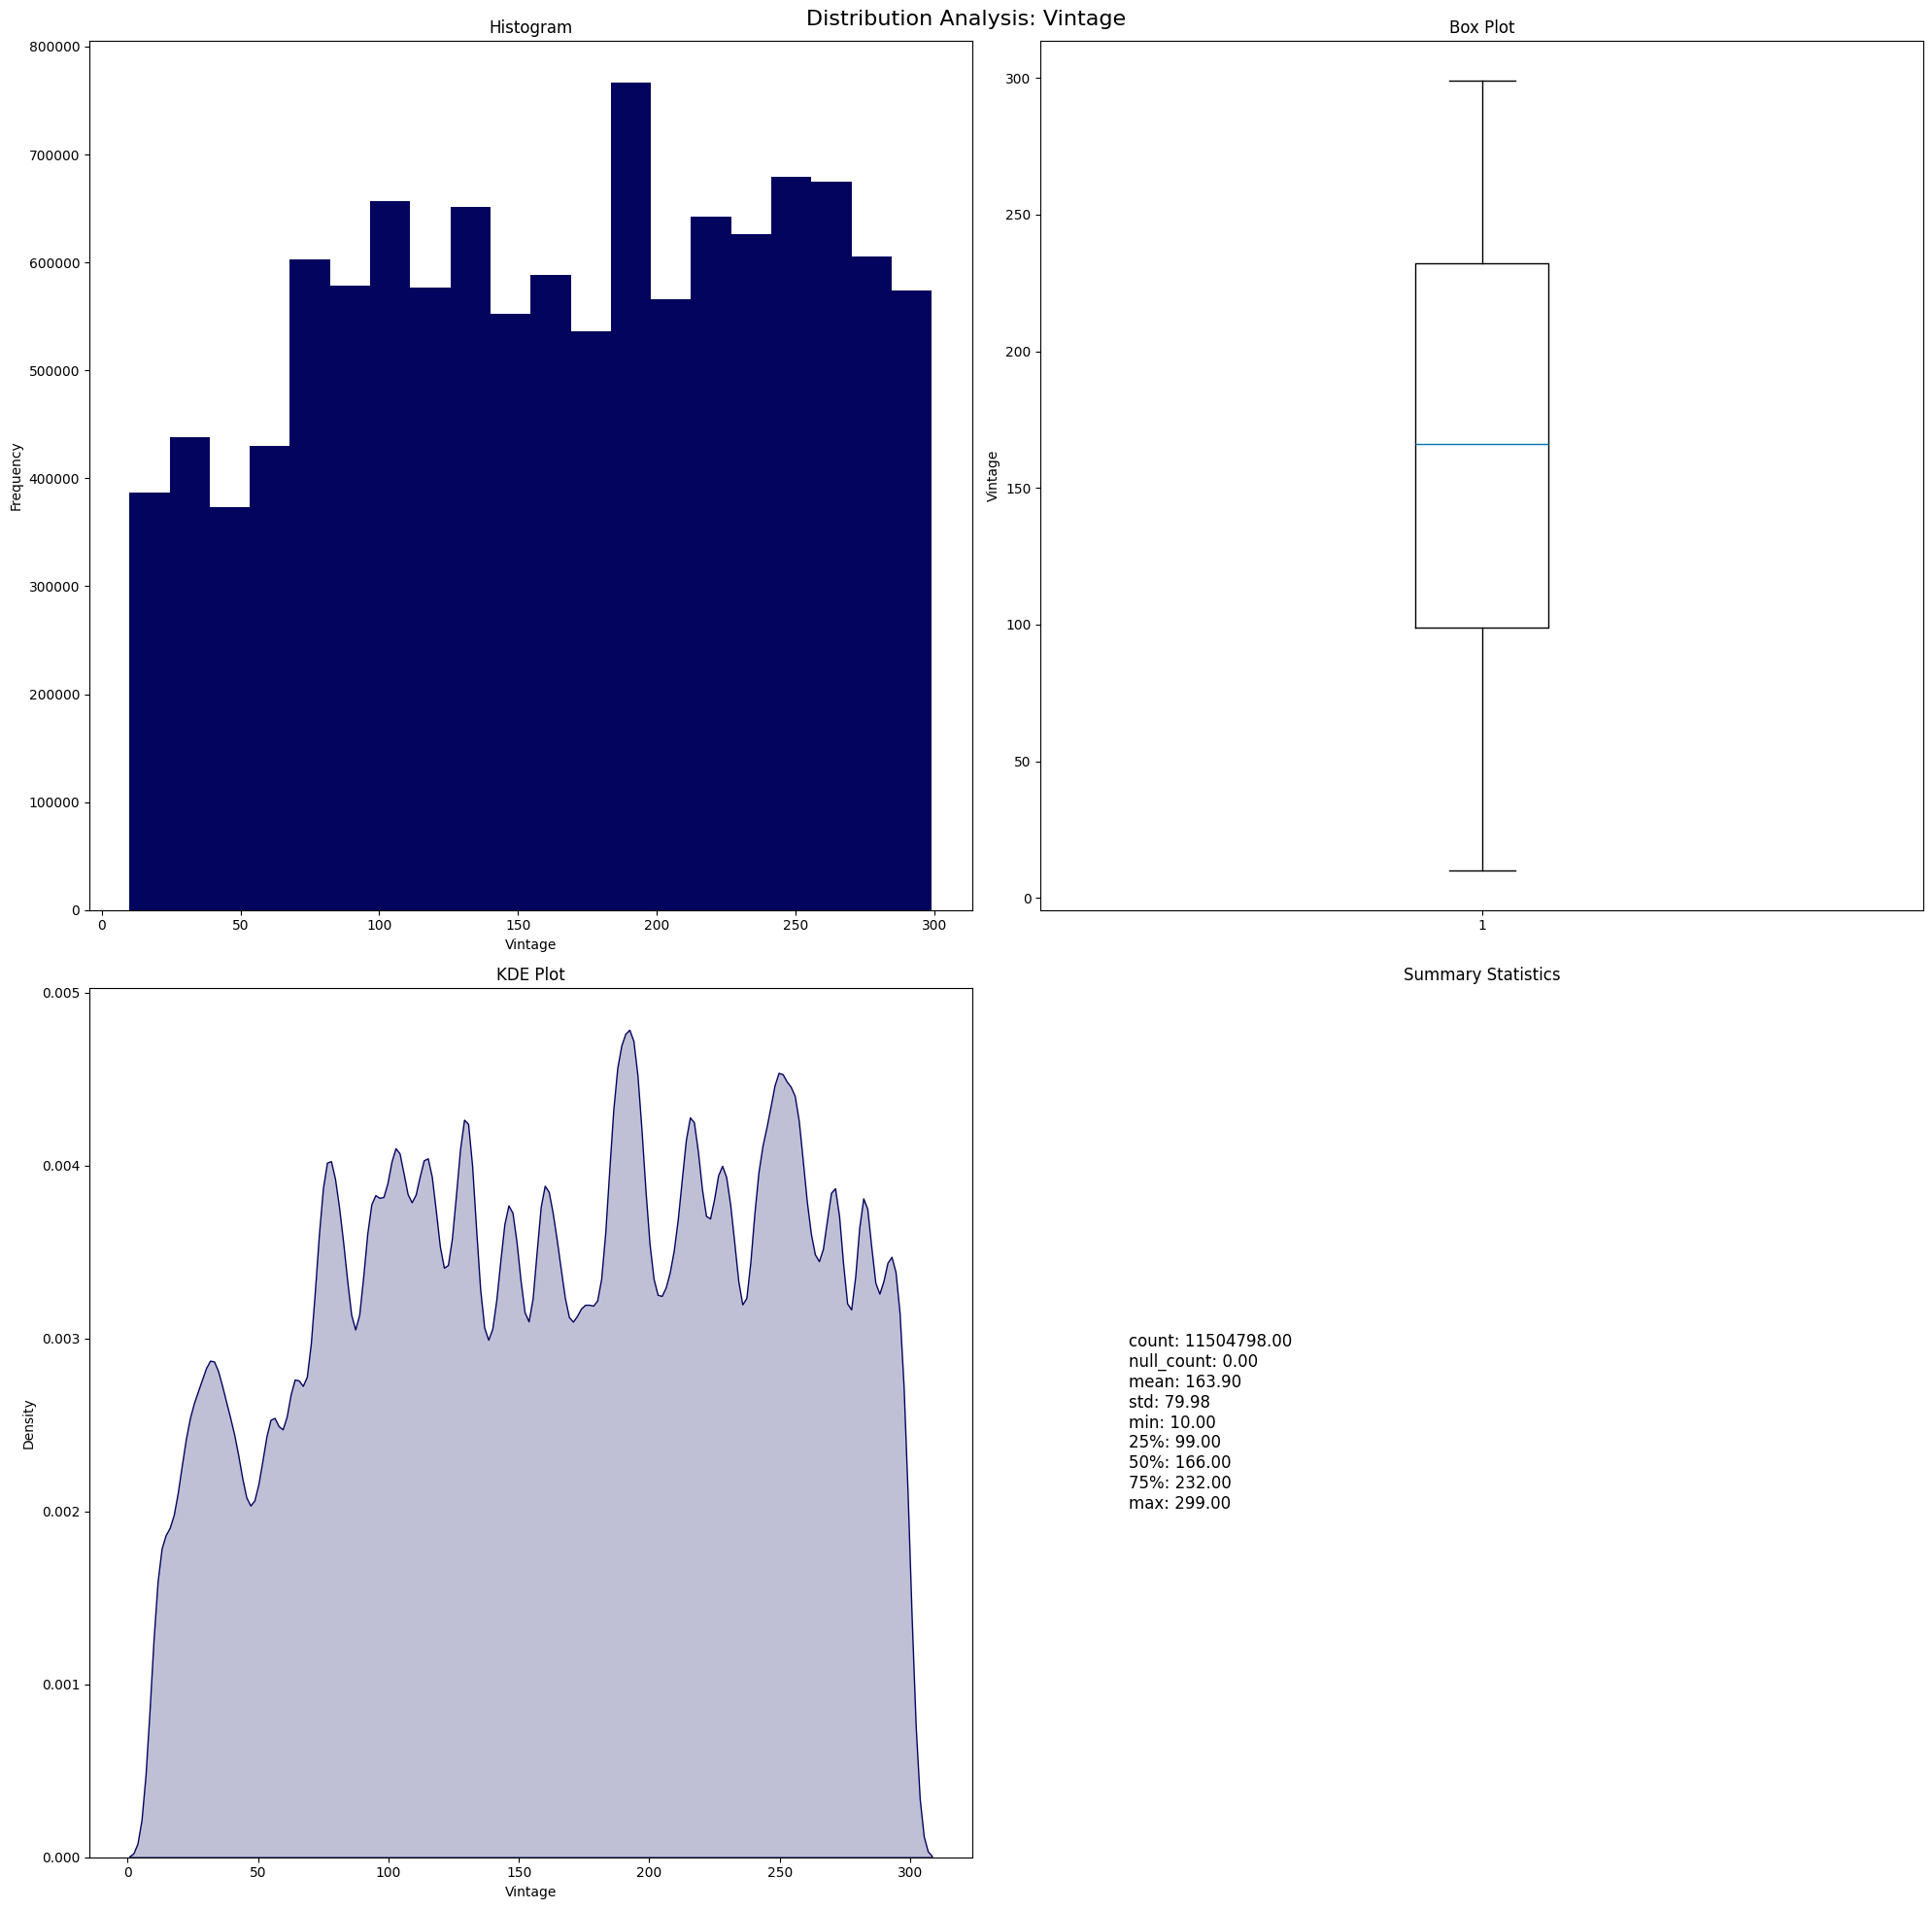

In [21]:
# Displaying general visualizations around the Vintage feature
if run_visualizations:
    display_continuous_distributions(continuous_feat = df['Vintage'])

### Feature 12: `Response`
Our last feature is our target class. As we can see, there is a strong imbalance here, which is something we'll want to be mindful of when performing our predictive modeling later on down in this notebook.

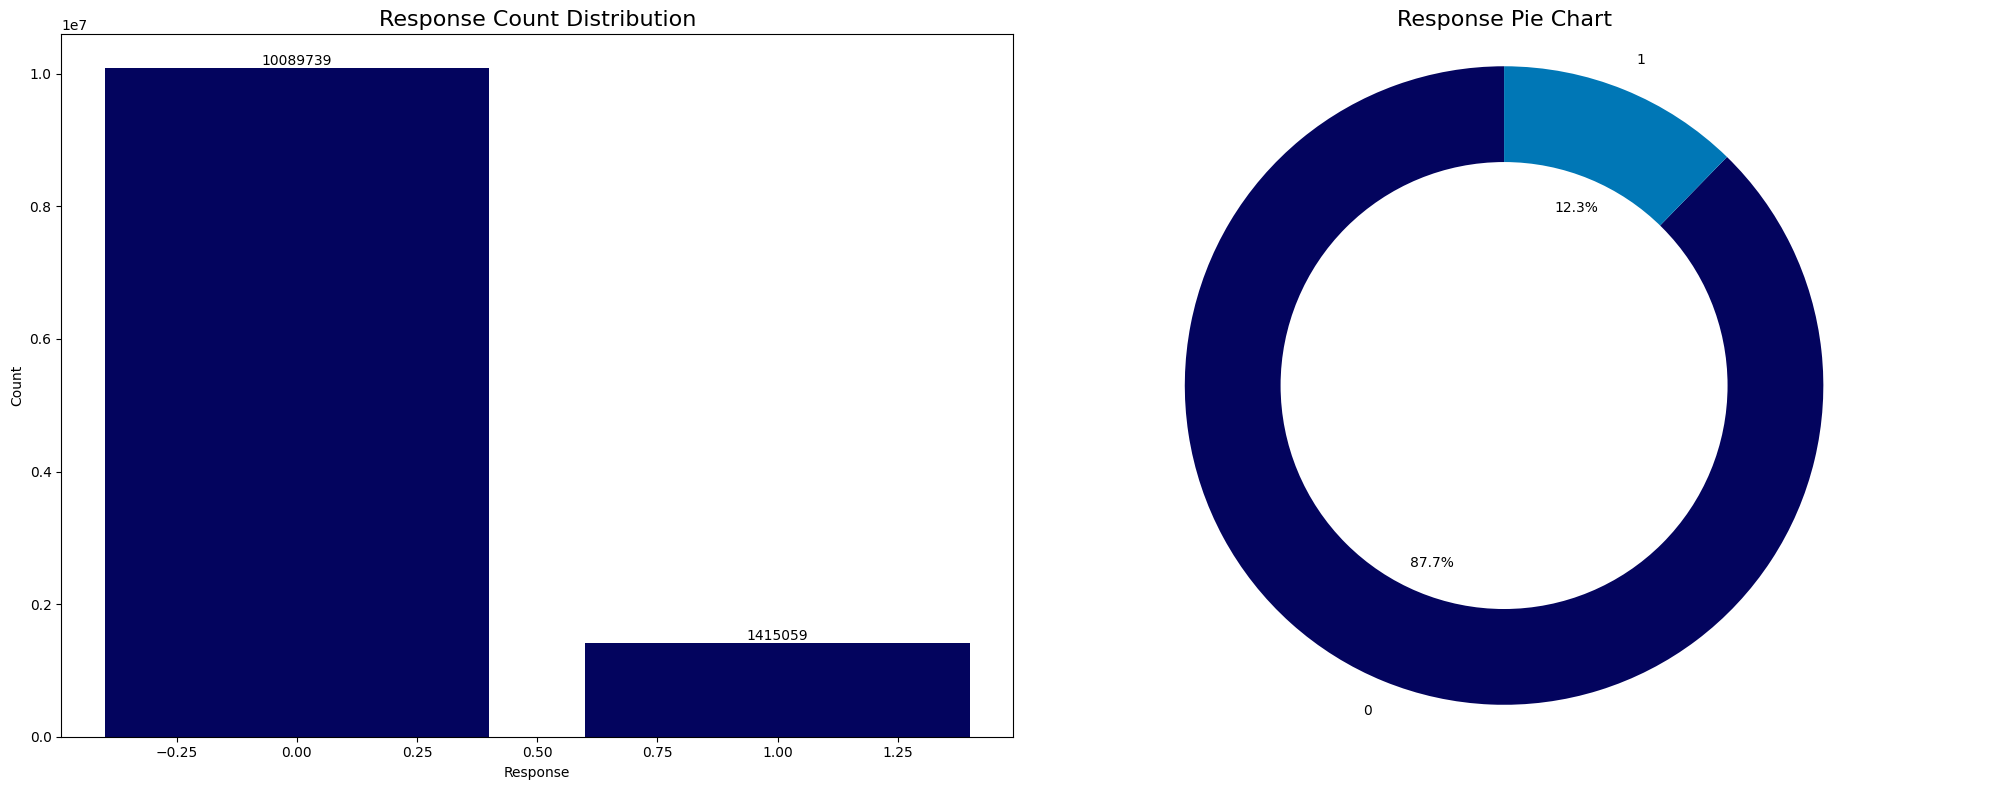

In [22]:
# Displaying general visualizations around the Response feature
if run_visualizations:
    display_binary_counts(binary_feat = df['Response'])

## Multivariate Analysis
Now that we have analyzed each feature on its own, we're going to use this section to see about combining these features together to see about engineering new features to use in our binary classification model. Because combining the permutations of all possible combinations isn't particularly feasible, we're going to hone in on features that seem to play well together.

### Comparing `Age` to `Vehicle_Damage`
I'm curious in checking out the correlation between these two variables since, in my opinion, there is a strong correlation between age and if a vehicle is damaged. Namely, younger drivers tend to be more reckless and thus be in greater accidents. Because `Vehicle_Damage` is a binary feature while `Age` is continous, let's calculate a **point-biserial correlation**. Additionally, we can create a KDE plot to visualize the correlation.

After calculating the point-biserial correlation, we can see that there is a statistically significant relationship per the p-value, but given that the correlation itself is ~0.29, the strength of the relationship isn't that strong. The KDE plot also seems to indicate something similar.

**Feature Engineering Plan:**
- None (It doesn't seem that there is strong enough of a correlation between these two variables to do anything about it.)

In [23]:
# Encoding the Vehicle_Damage feature
df = df.with_columns(
    pl.col('Vehicle_Damage').replace({
        'Yes': 1,
        'No': 0
    }).cast(pl.Int32).alias('Vehicle_Damage_Encoded')
)

In [24]:
# Caluculating the point-biserial correlation between Age and Vehicle_Damage
age = df['Age'].to_numpy()
vehicle_damage = df['Vehicle_Damage_Encoded'].to_numpy()

correlation, p_value = pointbiserialr(x = vehicle_damage, y = age)
print(f'Point-biserial correlation between Age and Vehicle_Damage: {correlation:.4f}')
print(f'P-value: {p_value:.10f}')

Point-biserial correlation between Age and Vehicle_Damage: 0.2880
P-value: 0.0000000000


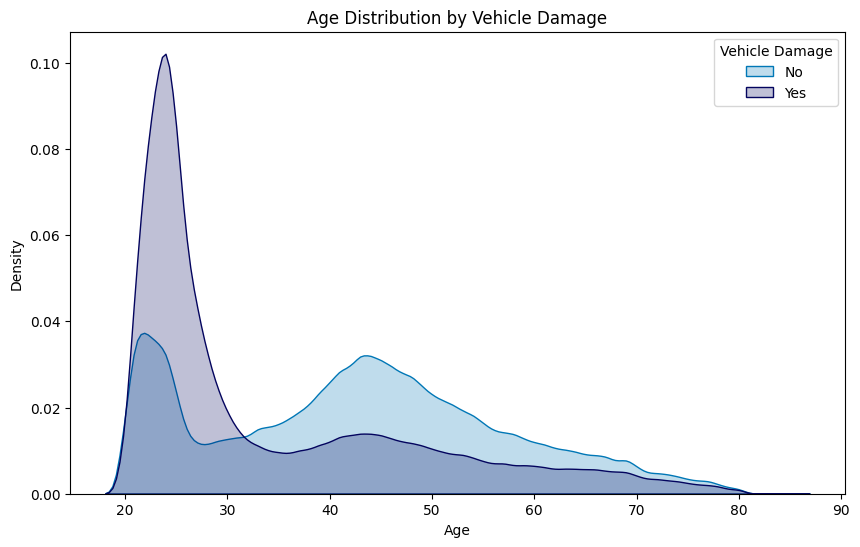

In [25]:
# Creating the KDE plot between Age and Vehicle Damage
if run_visualizations:
    plt.figure(figsize = (10, 6))
    sns.kdeplot(
        data = df,
        x = 'Age',
        hue = 'Vehicle_Damage_Encoded',
        fill = True,
        common_norm = False
    )
    plt.title('Age Distribution by Vehicle Damage')
    plt.xlabel('Age')
    plt.ylabel('Density')
    plt.legend(title = 'Vehicle Damage', labels = ['No', 'Yes'])
    plt.show()

### Comparing `Vehicle_Age` to `Vehicle_Damage`
If you think about people's driving patterns, generally people with newer vehicles tend to drive better than people with older vehicles. We can use a count plot to visualize these two features together to see if we want to engineer them together somehow.

**Feature Engineering Plans:**
- Engineer a new feature called `Vehicle_Age_Damage_Interaction` by multplying the encoded `Vehicle_Age` and `Vehicle_Damage` features, which would create the following 3 values as categories:
    - 0: Undamaged vehicles
    - 1: Middle-aged damaged vehicles
    - 2: Older damaged vehicles

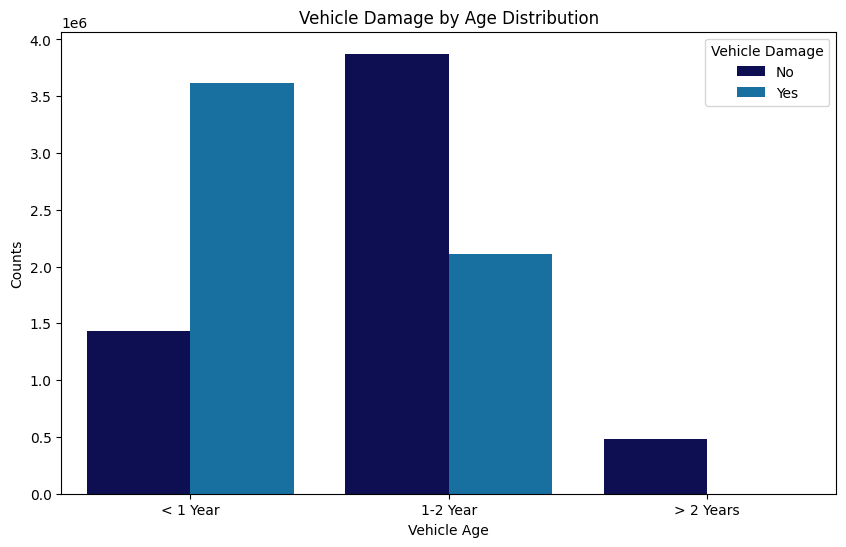

In [26]:
# Creating a visualization to compare Vehicle_Age to Vehicle_Damage
if run_visualizations:
    plt.figure(figsize = (10, 6))
    pd_df = df.to_pandas()
    sns.countplot(
        data = pd_df,
        x = 'Vehicle_Age',
        hue = 'Vehicle_Damage',
        order = ['< 1 Year', '1-2 Year', '> 2 Years']
    )
    plt.title('Vehicle Damage by Age Distribution')
    plt.xlabel('Vehicle Age')
    plt.ylabel('Counts')
    plt.legend(title = 'Vehicle Damage', labels = ['No', 'Yes'])

### Comparing `Age` to `Gender`
Thinking about typical driving patterns, there does tend to be a correlation between age and gender. For example, younger men tend to be a bit more reckless with their driving. We'll use a KDE plot below to see how these features compare to one another.

**Feature Engineering Plans:**
- None (There seems to be an equal distribution of `Age` compared to `Gender`, so it doesn't seem to make sense to engineer a new feature here.)

In [27]:
# Encoding the Gender feature
df = df.with_columns(
    pl.col('Gender').replace({
        'Female': 1,
        'Male': 0
    }).cast(pl.Int32)
    .alias('Gender_Encoded')
)

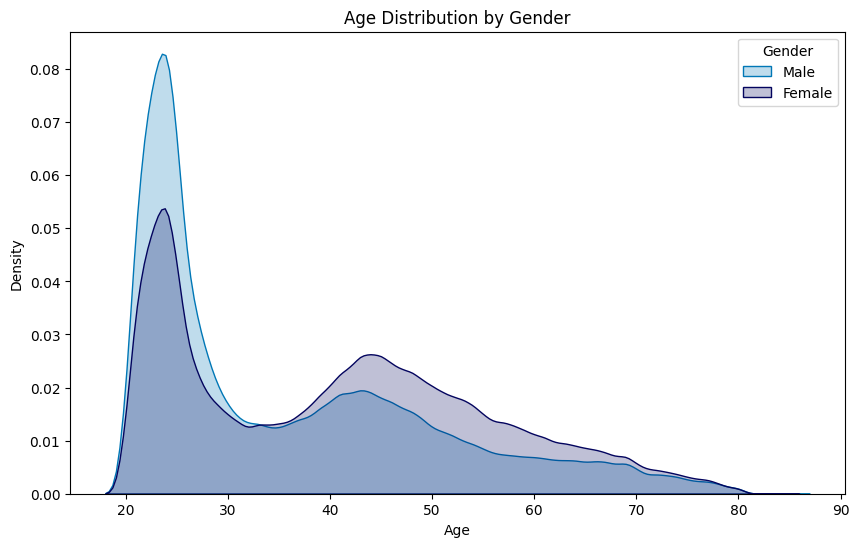

In [28]:
# Creating the KDE plot between Age and Gender
if run_visualizations:
    plt.figure(figsize = (10, 6))
    sns.kdeplot(
        data = df,
        x = 'Age',
        hue = 'Gender_Encoded',
        fill = True,
        common_norm = False
    )
    plt.title('Age Distribution by Gender')
    plt.xlabel('Age')
    plt.ylabel('Density')
    plt.legend(title = 'Gender', labels = ['Male', 'Female'])
    plt.show()

# Feature Engineering
Now that we have completed exploratory data analysis, we're ready to begin our feature engineering! Throughout the EDA secton, we made notes on what our plans for feature engineering would be. For your convenience, I have compiled them below:

- Drop the `id` feature entirely.
- Keep the `Driving_License` and `Vintage` features as is.
- Encode the `Gender`, `Previously_Insured`, and `Vehicle_Damage` features into numerical form.
- Use a Gaussian Mixture Model (GMM) to build a new feature around `Age` given the bimodal spikes in the data.
- One hot encode the `Vehicle_Age` feature as is.
- One hot encode the `Region_Code` after binning into three specific tiers:
    - Tier 1: All records in the `28.0` region code, which is the most represented region code
    - Tier 2: Any record in the following following top 7 represented categories after the `28.0` region code
    - Tier 3: All other records that do not fall in either tier above
- One hot encode the `Policy_Sales_Channel` feature after binning into four groups, where the first 3 groups represent the largest represented sales channels and the 4th one is a bucket for everything else.
- One hot encode currently continuous `Annual_Premium` feature by first turning it into a categorical feature with the three following categories:
    - A category referencing the largest class, which is a set value of 2630
    - A category representing all the premiums that fall within the IQR
    - A category to catch anything else not represented by the previous two categories
- Engineer a new one hot encoded feature called `Vehicle_Age_Damage_Interaction` by multplying the encoded `Vehicle_Age` and `Vehicle_Damage` features, which would create the following 3 values as categories:
    - 0: Undamaged vehicles
    - 1: Middle-aged damaged vehicles
    - 2: Older damaged vehicles

In [29]:
# Dropping features temporarily created from the EDA section
df = df.drop(['Vehicle_Damage_Encoded', 'Gender_Encoded'])

In [30]:
# Instantiating a general label encoder
general_label_encoder = LabelEncoder()

# Performing a label encoding on the Gender, Previously_Insured, and Vehicle_Damage features
for feat in ['Gender', 'Previously_Insured', 'Vehicle_Damage']:
    encoded_feat = general_label_encoder.fit_transform(df[feat])
    df = df.with_columns(pl.Series(feat, encoded_feat))

In [31]:
# Refactoring the Age data to prepare it for the Gaussian Mixture Model
age_data = df['Age'].to_numpy().reshape(-1, 1)

# Fitting the Age data to the Gaussian mixture model (GMM)
gaussian_mixture_model = GaussianMixture(n_components = 2, random_state = 42)
gaussian_mixture_model.fit(age_data)

# Generated the predicted probabilities of the GMM from the Age Data
age_gmm_probs = gaussian_mixture_model.predict_proba(age_data)

# Creating new temporary features to indicate the probability that an Age is close to each respective mode
df = df.with_columns([
    pl.Series(age_gmm_probs[:, 0]).alias('Age_Mode1_Prob'),
    pl.Series(age_gmm_probs[:, 1]).alias('Age_Mode2_Prob')
])

# Engineering a new feature to indicate if each record is close to one mode or the other
df = df.with_columns([
    pl.when(pl.col('Age_Mode1_Prob') > pl.col('Age_Mode2_Prob'))
    .then(0)
    .otherwise(1)
    .alias('Age_Closest_Mode')
])

# Dropping the temporary features
df = df.drop(['Age_Mode1_Prob', 'Age_Mode2_Prob'])

In [32]:
# Determining the top Region Codes
top_region = df['Region_Code'].value_counts().sort(by = 'count', descending = True)[0]['Region_Code'][0]
next_top_regions = df['Region_Code'].value_counts().sort(by = 'count', descending = True)[1:7]['Region_Code'].to_list()

# Engineering the new Region_Category feature
df = df.with_columns(
    pl.when(pl.col('Region_Code') == top_region).then(pl.lit('tier_1'))
      .when(pl.col('Region_Code').is_in(next_top_regions)).then(pl.lit('tier_2'))
      .otherwise(pl.lit('tier_3'))
      .alias('Region_Category')
)

In [33]:
# Determining the top policy sales channels categories
top_policy_sales_channels = df['Policy_Sales_Channel'].value_counts().sort(by = 'count', descending = True)[0:3]['Policy_Sales_Channel'].to_list()

# Engineering the new Policy_Sales_Channel_Category feature
df = df.with_columns(
    pl.when(pl.col('Region_Code') == top_policy_sales_channels[0]).then(pl.lit('tier_1'))
      .when(pl.col('Region_Code').is_in(top_policy_sales_channels[1:])).then(pl.lit('tier_2'))
      .otherwise(pl.lit('tier_3'))
      .alias('Policy_Sales_Channel_Category')
)

In [34]:
# Calculating the upper and lower bounds representing IQR for Annual Premium
lower_premium_bound = df['Annual_Premium'].quantile(0.25)
upper_premium_bound = df['Annual_Premium'].quantile(0.75)

# Getting the most frequent Premium payment amount
most_freq_premium = df['Annual_Premium'].value_counts().sort(by = 'count', descending = True)['Annual_Premium'][0]

# Engineering the new Annual_Premium_Category feature
df = df.with_columns(
    pl.when(pl.col('Annual_Premium') == most_freq_premium).then(pl.lit('tier_1'))
      .when((pl.col('Annual_Premium') >= lower_premium_bound) & (pl.col('Annual_Premium') <= upper_premium_bound)).then(pl.lit('tier_2'))
      .otherwise(pl.lit('tier_3'))
      .alias('Annual_Premium_Category')
)

In [35]:
# Creating a temporary feature to label encode the Vehicle Age feature
df = df.with_columns(
    pl.when(pl.col('Vehicle_Age') == '< 1 Year').then(0)
      .when(pl.col('Vehicle_Age') == '1-2 Year').then(1)
      .when(pl.col('Vehicle_Age') == '> 2 Years').then(2)
      .alias('Vehicle_Age_Label_Encoded')
)

# Engineering the new Vehicle_Age_Damage_Interaction feature
df = df.with_columns(
    (pl.col('Vehicle_Age_Label_Encoded') * pl.col('Vehicle_Damage')).alias('Vehicle_Age_Damage_Interaction')
)

# Dropping the temporary features
df = df.drop(['Vehicle_Age_Label_Encoded'])

In [36]:
# One hot encoding all features that require it
feats_to_ohe = [
    'Vehicle_Age',
    'Region_Category',
    'Policy_Sales_Channel_Category',
    'Annual_Premium_Category',
    'Vehicle_Age_Damage_Interaction'
]

# Performing the one hot encoding on all necessary features
df = df.to_dummies(
    columns = feats_to_ohe,
    separator = '_',
    drop_first = False
)

In [37]:
# Dropping any raw columns that have since been engineered
remaining_to_drop = [
    'Age',
    'Region_Code',
    'Annual_Premium',
    'Policy_Sales_Channel'
]

df = df.drop(remaining_to_drop)

In [38]:
# Viewing the first few rows of the final engineered dataset
df.head()

id,Gender,Driving_License,Previously_Insured,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage,Vintage,Response,Age_Closest_Mode,Region_Category_tier_1,Region_Category_tier_2,Region_Category_tier_3,Policy_Sales_Channel_Category_tier_2,Policy_Sales_Channel_Category_tier_3,Annual_Premium_Category_tier_1,Annual_Premium_Category_tier_2,Annual_Premium_Category_tier_3,Vehicle_Age_Damage_Interaction_0,Vehicle_Age_Damage_Interaction_1,Vehicle_Age_Damage_Interaction_2
i64,i64,i64,i64,u8,u8,u8,i64,i64,i64,i32,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8
0,1,1,0,1,0,0,1,187,0,0,0,0,1,0,1,0,0,1,0,1,0
1,1,1,0,0,0,1,1,288,1,1,1,0,0,0,1,0,0,1,0,0,1
2,0,1,1,0,1,0,0,254,0,0,0,0,1,0,1,0,1,0,1,0,0
3,0,1,0,1,0,0,1,76,0,1,0,0,1,0,1,1,0,0,0,1,0
4,0,1,1,1,0,0,0,294,0,1,0,1,0,0,1,0,1,0,1,0,0


In [39]:
# Viewing the columns of the final engineered dataset
df.columns

['id',
 'Gender',
 'Driving_License',
 'Previously_Insured',
 'Vehicle_Age_1-2 Year',
 'Vehicle_Age_< 1 Year',
 'Vehicle_Age_> 2 Years',
 'Vehicle_Damage',
 'Vintage',
 'Response',
 'Age_Closest_Mode',
 'Region_Category_tier_1',
 'Region_Category_tier_2',
 'Region_Category_tier_3',
 'Policy_Sales_Channel_Category_tier_2',
 'Policy_Sales_Channel_Category_tier_3',
 'Annual_Premium_Category_tier_1',
 'Annual_Premium_Category_tier_2',
 'Annual_Premium_Category_tier_3',
 'Vehicle_Age_Damage_Interaction_0',
 'Vehicle_Age_Damage_Interaction_1',
 'Vehicle_Age_Damage_Interaction_2']

# Predictive Modeling

In [40]:
# Separating the predictor features from the target class
X = df.drop(['Response', 'id'])
y = df['Response']

# Instantiating a Stratified K-Folds object
strat_kfolder = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

In [41]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)

In [42]:
def test_optuna_xgb_classifier(trial):
    
    # Setting the params for the XGBoost algorithm
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1.0, log = True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log = True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log = True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log = True)
    }
    
    # Instantiating the XGBoost model with the params defined above
    if gpu_enabled:
        model = xgb.XGBClassifier(**params, device = 'cuda', use_label_encoder = False, eval_metric = 'logloss')
    else:
        model = xgb.XGBClassifier(**params, use_label_encoder = False, eval_metric = 'logloss')
    
    # Fitting the training data to the model
    model.fit(X_train, y_train)
    
    # Getting the probabilistic inferences values using the validation dataset
    y_preds = model.predict_proba(X_val)[:, 1]
    
    # Calculating the ROC AUC score
    validation_score = roc_auc_score(y_val, y_preds)
    
    return validation_score



def test_optuna_rfc_classifier(trial):
    
    # Setting the params for the RandomForestClassifier algorithm
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }
    
    # Instantiating the RandomForestClassifier model with the params defined above
#     if gpu_enabled:
#         from cuml.ensemble import RandomForestClassifier
#         model = RandomForestClassifier(**params, random_state = 42)
#     else:
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(**params, random_state = 42)
    
    # Fitting the training data to the model
    model.fit(X_train, y_train)
    
    # Getting the probabilistic inferences values using the validation dataset
    y_preds = model.predict_proba(X_val)[:, 1]
    
    # Calculating the ROC AUC score
    validation_score = roc_auc_score(y_val, y_preds)
    
    return validation_score


In [43]:
# study = optuna.create_study(direction = 'maximize')
# study.optimize(test_optuna_rfc_classifier, n_trials = 5)
%time
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state = 42)
model.fit(X_train, y_train)

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 μs
Wall time: 3.1 μs


RandomForestClassifier(random_state=42)

In [44]:
y_preds = model.predict_proba(X_val)[:, 1]
validation_score = roc_auc_score(y_val, y_preds)
print(validation_score)

0.8553616189539123


In [45]:
# Iterating over each of the 5 folds in the stratified K-Fold
# for fold, (train_index, val_index) in enumerate(strat_kfolder.split(X, y), 1):
    
#     # Setting the train and validation sets for this split
#     X_train, X_val = X[train_index], X[val_index]
#     y_train, y_val = y[train_index], y[val_index]
#     print(X_train.head())
#     print('\n\n\n')

In [46]:
len(X_train)

9203838

# Closing Thoughts / Retrospective